In [1]:
from module import *
import requests
import time
import pandas as pd
import ast
import numpy as np
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.metrics import silhouette_score
import seaborn as sns
import joblib

API Key loaded successfully!


In [2]:
response = requests.get(f"https://rawg.io/api/games?key={rawg_api_key}&page_size=40&token=") 
print("status code: ",response.status_code)
print("Response json structure: ")
print(response.json().keys())

status code:  200
Response json structure: 
dict_keys(['count', 'next', 'previous', 'results', 'seo_title', 'seo_description', 'seo_keywords', 'seo_h1', 'noindex', 'nofollow', 'description', 'filters', 'nofollow_collections'])


In [3]:
print(response.json()["next"])
print(response.json()["count"])
print(len(response.json()["results"]))
print(response.json()["results"][4])

https://api.rawg.io/api/games?key=caaf4a3eaa414efc8b8104222607204c&page=2&page_size=40&token=
865564
40
{'id': 5286, 'slug': 'tomb-raider', 'name': 'Tomb Raider (2013)', 'released': '2013-03-05', 'tba': False, 'background_image': 'https://media.rawg.io/media/games/021/021c4e21a1824d2526f925eff6324653.jpg', 'rating': 4.05, 'rating_top': 4, 'ratings': [{'id': 4, 'title': 'recommended', 'count': 2356, 'percent': 60.53}, {'id': 5, 'title': 'exceptional', 'count': 992, 'percent': 25.49}, {'id': 3, 'title': 'meh', 'count': 425, 'percent': 10.92}, {'id': 1, 'title': 'skip', 'count': 119, 'percent': 3.06}], 'ratings_count': 3863, 'reviews_text_count': 14, 'added': 16374, 'added_by_status': {'yet': 674, 'owned': 10596, 'beaten': 4192, 'toplay': 263, 'dropped': 538, 'playing': 111}, 'metacritic': 86, 'playtime': 10, 'suggestions_count': 646, 'updated': '2024-03-30T18:27:33', 'user_game': None, 'reviews_count': 3892, 'saturated_color': '0f0f0f', 'dominant_color': '0f0f0f', 'platforms': [{'platfor

In [29]:
# We create a list to store the games and we proceed to extend it using the first previous results
games = []
games.extend(response.json()["results"])
len(games)

In [31]:
# In case the api call fails we store a list of next pages to continue where it failed
next_pages = []
next_pages.append(response.json()["next"])

In [4]:
# Retrieve a list of games
next_page = next_pages[-1]
while next_page:
    time.sleep(1)
    response = requests.get(next_page)
    
    if response.status_code == 200:
        next_page = response.json()["next"]
        next_pages.append(response.json()["next"])
        if len(response.json()["results"]) > 0:
            for game in response.json()["results"]:
                games.append(game)
        else:
            print("Response returned 0 records")
    else:
        print("Request failed with code: ",response.status_code)

In [47]:
# Last run lasted almost 2 hours with 110,480 records
len(games)

110480

In [49]:
# Create a dataframe using  the games retrieved from the api
df = pd.DataFrame(games)
df.head()

,id,slug,name,released,tba,background_image,rating,rating_top,ratings,ratings_count,reviews_text_count,added,added_by_status,metacritic,playtime,suggestions_count,updated,user_game,reviews_count,saturated_color,dominant_color,platforms,parent_platforms,genres,stores,clip,tags,esrb_rating,short_screenshots,community_rating
0,3498,grand-theft-auto-v,Grand Theft Auto V,2013-09-17,False,https://media.rawg.io/media/games/20a/20aa03a1...,4.47,5,"[{'id': 5, 'title': 'exceptional', 'count': 40...",6777,59,20664,"{'yet': 526, 'owned': 11815, 'beaten': 5888, '...",92.0,74,431,2024-04-04T09:23:28,None,6878,0f0f0f,0f0f0f,"[{'platform': {'id': 4, 'name': 'PC', 'slug': ...","[{'platform': {'id': 1, 'name': 'PC', 'slug': ...","[{'id': 4, 'name': 'Action', 'slug': 'action',...","[{'id': 290375, 'store': {'id': 3, 'name': 'Pl...",None,"[{'id': 31, 'name': 'Singleplayer', 'slug': 's...","{'id': 4, 'name': 'Mature', 'slug': 'mature'}","[{'id': -1, 'image': 'https://media.rawg.io/me...",NaN
1,3328,the-witcher-3-wild-hunt,The Witcher 3: Wild Hunt,2015-05-18,False,https://media.rawg.io/media/games/618/618c2031...,4.65,5,"[{'id': 5, 'title': 'exceptional', 'count': 50...",6489,73,19980,"{'yet': 1115, 'owned': 11499, 'beaten': 4787, ...",92.0,45,675,2024-04-05T08:46:03,None,6595,0f0f0f,0f0f0f,"[{'platform': {'id': 186, 'name': 'Xbox Series...","[{'platform': {'id': 1, 'name': 'PC', 'slug': ...","[{'id': 4, 'name': 'Action', 'slug': 'action',...","[{'id': 354780, 'store': {'id': 5, 'name': 'GO...",None,"[{'id': 31, 'name': 'Singleplayer', 'slug': 's...","{'id': 4, 'name': 'Mature', 'slug': 'mature'}","[{'id': -1, 'image': 'https://media.rawg.io/me...",NaN
2,4200,portal-2,Portal 2,2011-04-18,False,https://media.rawg.io/media/games/2ba/2bac0e87...,4.61,5,"[{'id': 5, 'title': 'exceptional', 'count': 39...",5615,35,18820,"{'yet': 614, 'owned': 11617, 'beaten': 5477, '...",95.0,11,550,2024-04-04T09:25:19,None,5668,0f0f0f,0f0f0f,"[{'platform': {'id': 16, 'name': 'PlayStation ...","[{'platform': {'id': 1, 'name': 'PC', 'slug': ...","[{'id': 2, 'name': 'Shooter', 'slug': 'shooter...","[{'id': 465889, 'store': {'id': 2, 'name': 'Xb...",None,"[{'id': 31, 'name': 'Singleplayer', 'slug': 's...","{'id': 2, 'name': 'Everyone 10+', 'slug': 'eve...","[{'id': -1, 'image': 'https://media.rawg.io/me...",NaN
3,4291,counter-strike-global-offensive,Counter-Strike: Global Offensive,2012-08-21,False,https://media.rawg.io/media/games/736/73619bd3...,3.57,4,"[{'id': 4, 'title': 'recommended', 'count': 16...",3443,26,16389,"{'yet': 262, 'owned': 12402, 'beaten': 1025, '...",81.0,65,587,2024-04-04T09:24:02,None,3478,0f0f0f,0f0f0f,"[{'platform': {'id': 4, 'name': 'PC', 'slug': ...","[{'platform': {'id': 1, 'name': 'PC', 'slug': ...","[{'id': 2, 'name': 'Shooter', 'slug': 'shooter...","[{'id': 4619, 'store': {'id': 3, 'name': 'Play...",None,"[{'id': 40847, 'name': 'Steam Achievements', '...","{'id': 4, 'name': 'Mature', 'slug': 'mature'}","[{'id': -1, 'image': 'https://media.rawg.io/me...",NaN
4,5286,tomb-raider,Tomb Raider (2013),2013-03-05,False,https://media.rawg.io/media/games/021/021c4e21...,4.05,4,"[{'id': 4, 'title': 'recommended', 'count': 23...",3863,14,16297,"{'yet': 674, 'owned': 10518, 'beaten': 4193, '...",86.0,10,646,2024-03-30T18:27:33,None,3892,0f0f0f,0f0f0f,"[{'platform': {'id': 18, 'name': 'PlayStation ...","[{'platform': {'id': 1, 'name': 'PC', 'slug': ...","[{'id': 4, 'name': 'Action', 'slug': 'action',...","[{'id': 33824, 'store': {'id': 7, 'name': 'Xbo...",None,"[{'id': 31, 'name': 'Singleplayer', 'slug': 's...","{'id': 4, 'name': 'Mature', 'slug': 'mature'}","[{'id': -1, 'image': 'https://media.rawg.io/me...",NaN


In [51]:
print("shape: ",df.shape)
print(df.dtypes)
df.columns

shape:  (110480, 30)
id                      int64
slug                   object
name                   object
released               object
tba                      bool
background_image       object
rating                float64
rating_top              int64
ratings                object
ratings_count           int64
reviews_text_count      int64
added                   int64
added_by_status        object
metacritic            float64
playtime                int64
suggestions_count       int64
updated                object
user_game              object
reviews_count           int64
saturated_color        object
dominant_color         object
platforms              object
parent_platforms       object
genres                 object
stores                 object
clip                   object
tags                   object
esrb_rating            object
short_screenshots      object
community_rating      float64
dtype: object


Index(['id', 'slug', 'name', 'released', 'tba', 'background_image', 'rating',
       'rating_top', 'ratings', 'ratings_count', 'reviews_text_count', 'added',
       'added_by_status', 'metacritic', 'playtime', 'suggestions_count',
       'updated', 'user_game', 'reviews_count', 'saturated_color',
       'dominant_color', 'platforms', 'parent_platforms', 'genres', 'stores',
       'clip', 'tags', 'esrb_rating', 'short_screenshots', 'community_rating'],
      dtype='object')

In [2]:
# Export the records to a csv
#df.to_csv("games110480.csv")
# Import csv
data_frame = pd.read_csv("data/games110480.csv")

In [3]:
data_frame.head()

,Unnamed: 0,id,slug,name,released,tba,background_image,rating,rating_top,ratings,ratings_count,reviews_text_count,added,added_by_status,metacritic,playtime,suggestions_count,updated,user_game,reviews_count,saturated_color,dominant_color,platforms,parent_platforms,genres,stores,clip,tags,esrb_rating,short_screenshots,community_rating
0,0,3498,grand-theft-auto-v,Grand Theft Auto V,2013-09-17,False,https://media.rawg.io/media/games/20a/20aa03a1...,4.47,5,"[{'id': 5, 'title': 'exceptional', 'count': 40...",6777,59,20664,"{'yet': 526, 'owned': 11815, 'beaten': 5888, '...",92.0,74,431,2024-04-04T09:23:28,NaN,6878,0f0f0f,0f0f0f,"[{'platform': {'id': 4, 'name': 'PC', 'slug': ...","[{'platform': {'id': 1, 'name': 'PC', 'slug': ...","[{'id': 4, 'name': 'Action', 'slug': 'action',...","[{'id': 290375, 'store': {'id': 3, 'name': 'Pl...",NaN,"[{'id': 31, 'name': 'Singleplayer', 'slug': 's...","{'id': 4, 'name': 'Mature', 'slug': 'mature'}","[{'id': -1, 'image': 'https://media.rawg.io/me...",NaN
1,1,3328,the-witcher-3-wild-hunt,The Witcher 3: Wild Hunt,2015-05-18,False,https://media.rawg.io/media/games/618/618c2031...,4.65,5,"[{'id': 5, 'title': 'exceptional', 'count': 50...",6489,73,19980,"{'yet': 1115, 'owned': 11499, 'beaten': 4787, ...",92.0,45,675,2024-04-05T08:46:03,NaN,6595,0f0f0f,0f0f0f,"[{'platform': {'id': 186, 'name': 'Xbox Series...","[{'platform': {'id': 1, 'name': 'PC', 'slug': ...","[{'id': 4, 'name': 'Action', 'slug': 'action',...","[{'id': 354780, 'store': {'id': 5, 'name': 'GO...",NaN,"[{'id': 31, 'name': 'Singleplayer', 'slug': 's...","{'id': 4, 'name': 'Mature', 'slug': 'mature'}","[{'id': -1, 'image': 'https://media.rawg.io/me...",NaN
2,2,4200,portal-2,Portal 2,2011-04-18,False,https://media.rawg.io/media/games/2ba/2bac0e87...,4.61,5,"[{'id': 5, 'title': 'exceptional', 'count': 39...",5615,35,18820,"{'yet': 614, 'owned': 11617, 'beaten': 5477, '...",95.0,11,550,2024-04-04T09:25:19,NaN,5668,0f0f0f,0f0f0f,"[{'platform': {'id': 16, 'name': 'PlayStation ...","[{'platform': {'id': 1, 'name': 'PC', 'slug': ...","[{'id': 2, 'name': 'Shooter', 'slug': 'shooter...","[{'id': 465889, 'store': {'id': 2, 'name': 'Xb...",NaN,"[{'id': 31, 'name': 'Singleplayer', 'slug': 's...","{'id': 2, 'name': 'Everyone 10+', 'slug': 'eve...","[{'id': -1, 'image': 'https://media.rawg.io/me...",NaN
3,3,4291,counter-strike-global-offensive,Counter-Strike: Global Offensive,2012-08-21,False,https://media.rawg.io/media/games/736/73619bd3...,3.57,4,"[{'id': 4, 'title': 'recommended', 'count': 16...",3443,26,16389,"{'yet': 262, 'owned': 12402, 'beaten': 1025, '...",81.0,65,587,2024-04-04T09:24:02,NaN,3478,0f0f0f,0f0f0f,"[{'platform': {'id': 4, 'name': 'PC', 'slug': ...","[{'platform': {'id': 1, 'name': 'PC', 'slug': ...","[{'id': 2, 'name': 'Shooter', 'slug': 'shooter...","[{'id': 4619, 'store': {'id': 3, 'name': 'Play...",NaN,"[{'id': 40847, 'name': 'Steam Achievements', '...","{'id': 4, 'name': 'Mature', 'slug': 'mature'}","[{'id': -1, 'image': 'https://media.rawg.io/me...",NaN
4,4,5286,tomb-raider,Tomb Raider (2013),2013-03-05,False,https://media.rawg.io/media/games/021/021c4e21...,4.05,4,"[{'id': 4, 'title': 'recommended', 'count': 23...",3863,14,16297,"{'yet': 674, 'owned': 10518, 'beaten': 4193, '...",86.0,10,646,2024-03-30T18:27:33,NaN,3892,0f0f0f,0f0f0f,"[{'platform': {'id': 18, 'name': 'PlayStation ...","[{'platform': {'id': 1, 'name': 'PC', 'slug': ...","[{'id': 4, 'name': 'Action', 'slug': 'action',...","[{'id': 33824, 'store': {'id': 7, 'name': 'Xbo...",NaN,"[{'id': 31, 'name': 'Singleplayer', 'slug': 's...","{'id': 4, 'name': 'Mature', 'slug': 'mature'}","[{'id': -1, 'image': 'https://media.rawg.io/me...",NaN


In [4]:
df2 = clean_format_and_export(data_frame, False)

* Applied first filter, new shape:  (16043, 17)
* Completed string to object and json normalize operations \o/ \o/
* Finished replacing and filtering nans.
* Created export csv file named:  15758_games_formatted_clean.csv
* Finished formatting rating columns
* Created export csv file ready for clustering named:  15758_games_clean_formatted_ready_4_clustering.csv


In [6]:
df2.head()

,name,released,background_image,rating,rating_top,ratings_count,playtime,suggestions_count,reviews_count,platform_name_0,platform_name_1,platform_name_2,platform_name_3,platform_name_4,platform_name_5,platform_name_6,genre_0,genre_1,tags_extracted,exceptional_,recommended_,meh_,skip_
0,Grand Theft Auto V,2013-09-17,https://media.rawg.io/media/games/20a/20aa03a1...,4.47,5.0,6777.0,74.0,431.0,6878.0,PC,PlayStation 5,Xbox Series S/X,PlayStation 4,PlayStation 3,Xbox 360,Xbox One,Action,undefined,"['Singleplayer', 'Multiplayer']",58.99,32.83,6.35,1.83
1,The Witcher 3: Wild Hunt,2015-05-18,https://media.rawg.io/media/games/618/618c2031...,4.65,5.0,6489.0,45.0,675.0,6595.0,Xbox Series S/X,PlayStation 5,macOS,PlayStation 4,Nintendo Switch,PC,Xbox One,Action,RPG,['Singleplayer'],77.15,16.12,4.20,2.53
2,Portal 2,2011-04-18,https://media.rawg.io/media/games/2ba/2bac0e87...,4.61,5.0,5615.0,11.0,550.0,5668.0,PlayStation 3,PC,Xbox 360,Linux,macOS,Xbox One,undefined,Shooter,Puzzle,"['Singleplayer', 'Multiplayer']",70.15,24.95,2.70,2.21
3,Counter-Strike: Global Offensive,2012-08-21,https://media.rawg.io/media/games/736/73619bd3...,3.57,4.0,3443.0,65.0,587.0,3478.0,PC,Linux,Xbox 360,PlayStation 3,undefined,undefined,undefined,Shooter,undefined,['Multiplayer'],16.10,46.81,25.91,11.18
4,Tomb Raider (2013),2013-03-05,https://media.rawg.io/media/games/021/021c4e21...,4.05,4.0,3863.0,10.0,646.0,3892.0,PlayStation 4,macOS,PC,Xbox One,Xbox 360,PlayStation 3,undefined,Action,undefined,"['Singleplayer', 'Multiplayer']",25.49,60.53,10.92,3.06


In [7]:
# Select the numericals
numericals = df2.copy().select_dtypes(np.number)

In [8]:
numericals.head(3)

,rating,rating_top,ratings_count,playtime,suggestions_count,reviews_count,exceptional_,recommended_,meh_,skip_
0,4.47,5.0,6777.0,74.0,431.0,6878.0,58.99,32.83,6.35,1.83
1,4.65,5.0,6489.0,45.0,675.0,6595.0,77.15,16.12,4.20,2.53
2,4.61,5.0,5615.0,11.0,550.0,5668.0,70.15,24.95,2.70,2.21


In [9]:
numericals.isna().sum()
# Noticed that removing "reviews_count" and "playtime" columns reduces inertia, increases silhouette score and visualizer shows improvements
numericals.drop(["reviews_count"], axis=1, inplace=True)
numericals.drop(["playtime"], axis=1, inplace=True)


In [10]:
# K-Means is a distance based algorithm: we need to scale / normalize:
X_prep = StandardScaler().fit_transform(numericals)

# Now, all features will have the same weight.
pd.DataFrame(X_prep).head()

,0,1,2,3,4,5,6,7
0,1.606095,1.300066,22.614531,0.455100,2.737924,0.188940,-0.626975,-0.670699
1,1.897832,1.300066,21.638955,1.833466,3.810971,-0.505597,-0.750817,-0.621235
2,1.833002,1.300066,18.678355,1.127336,3.397352,-0.138585,-0.837218,-0.643847
3,0.147411,0.289538,11.320891,1.336351,0.203618,0.770008,0.499692,-0.010003
4,0.925376,0.289538,12.743605,1.669644,0.758459,1.340268,-0.363741,-0.583784


In [11]:
corr_df = pd.DataFrame(X_prep).corr()
corr_df.columns = numericals.columns

In [12]:
# We print out the columns that has a correlation higher than the threshold 0.80
def filter_high_corr(corr_matrix, threshold=0.80):
    highly_correlated = corr_matrix[abs(corr_matrix) >= threshold]  # Filter directly
    return highly_correlated.stack().reset_index().rename(columns={0: 'correlation'})

high_correlations = filter_high_corr(corr_df)
print(high_correlations)

   level_0            level_1  correlation
0        0             rating          1.0
1        1         rating_top          1.0
2        2      ratings_count          1.0
3        3  suggestions_count          1.0
4        4       exceptional_          1.0
5        5       recommended_          1.0
6        6               meh_          1.0
7        7              skip_          1.0


Text(0.5, 1.0, 'Elbow Method showing the optimal k')

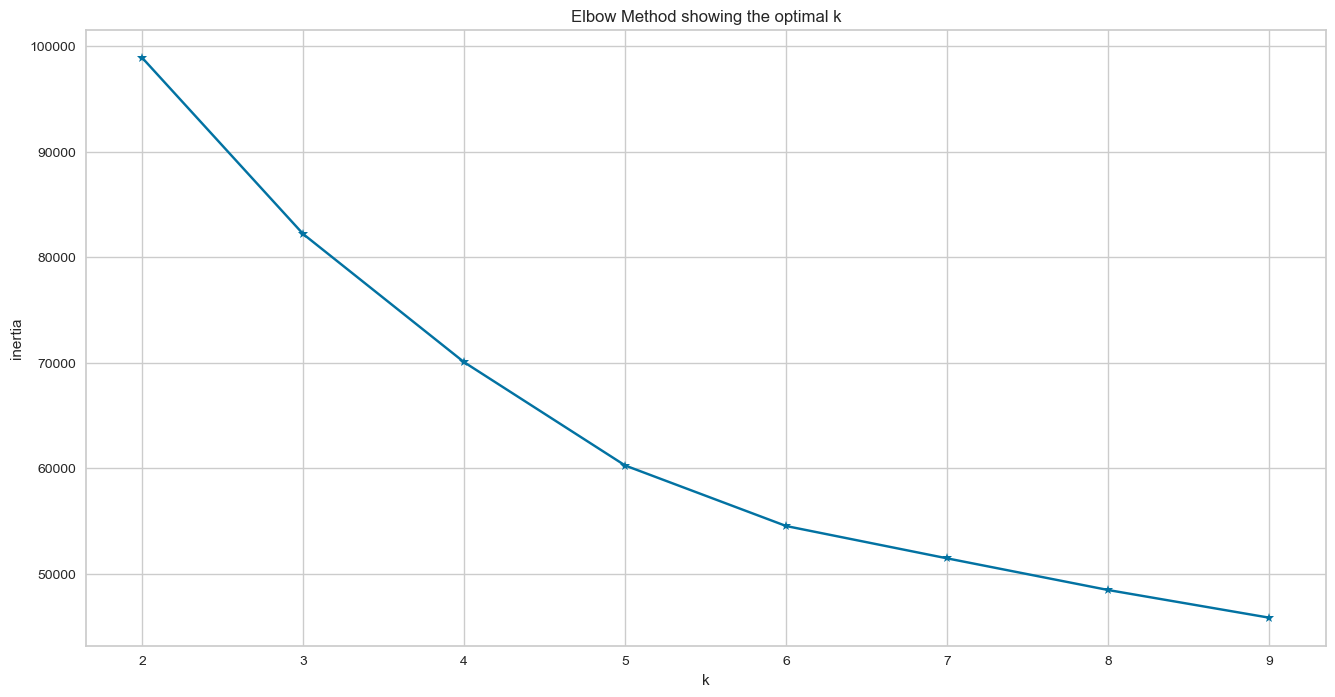

In [13]:
K = range(2, 10)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_prep)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(16,8))
plt.plot(K, inertia, marker = '*')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

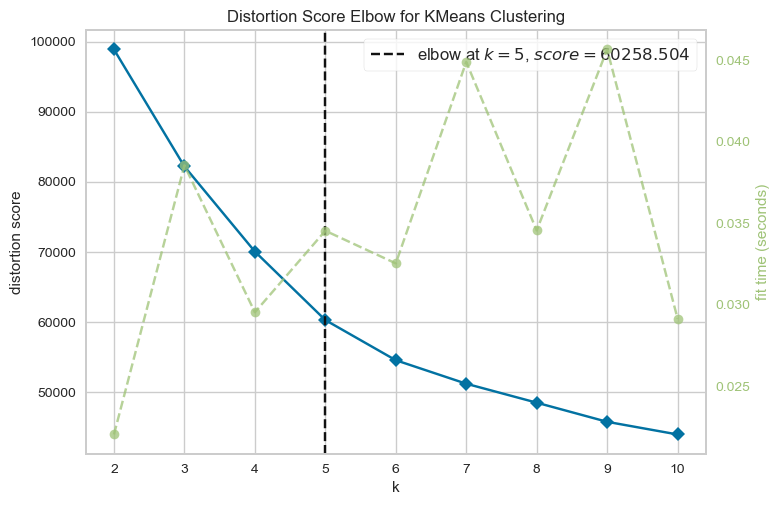

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [14]:
# Elbow method
kmeans_visualizer = KElbowVisualizer(KMeans(),K=(4,12))
kmeans_visualizer.fit(X_prep)
kmeans_visualizer.show()

In [15]:
# Clustering 4:
kmeans4 = KMeans(n_clusters=4, random_state=1234)
kmeans4.fit(X_prep)
kmeans4.fit_predict(X_prep)
labels4 = kmeans4.labels_

In [16]:
# Clustering 5:
kmeans5 = KMeans(n_clusters=5, random_state=1234)
kmeans5.fit(X_prep)
kmeans5.fit_predict(X_prep)
labels5 = kmeans5.labels_

In [17]:
# Clustering 6:
kmeans6 = KMeans(n_clusters=6, random_state=1234)
kmeans6.fit(X_prep)
kmeans6.fit_predict(X_prep)
labels6 = kmeans6.labels_

In [18]:
# Clustering 7:
kmeans7 = KMeans(n_clusters=7, random_state=1234)
kmeans7.fit(X_prep)
kmeans7.fit_predict(X_prep)
labels7 = kmeans7.labels_

In [19]:
print([kmeans4.inertia_,kmeans5.inertia_,kmeans6.inertia_,kmeans7.inertia_])
min([kmeans4.inertia_,kmeans5.inertia_,kmeans6.inertia_, kmeans7.inertia_])

[70040.50543397777, 60258.69430919249, 54526.95186339158, 51464.50167337551]


51464.50167337551

first run
[92579.70348946989, 80986.92914070253, 71338.4073004413, 65576.62415576629]

65576.62415576629
------
after removing "reviews_count"
[85706.03312031488, 75774.95873970508, 66214.27788717014, 60482.143737179846]

60482.143737179846
------
after removing "playtime"
[70042.15968303423, 60260.12145287158, 54528.221714493, 51172.853964116824]

51172.853964116824

The winner for less inertia is cluster=7

In [20]:
print(silhouette_score(X_prep, labels4))
print(silhouette_score(X_prep, labels5))
print(silhouette_score(X_prep, labels6))
print(silhouette_score(X_prep, labels7))

0.30183938646475306
0.30924984056475063
0.29935794229894036
0.2854873436205107


first run silhouette_score
0.28750905576426905
0.3001603301617199
0.3010667514381259
0.29293934258548043
------
after removing "reviews_count"
0.29442384687563117
0.30134069717939727
0.3030687071743616
0.29384260498802717
------
after removing "playtime"
0.3017835901167892
0.30913592473676266
0.2993117714484657
0.282864604821538

The winner for better silhouette score is cluster=5

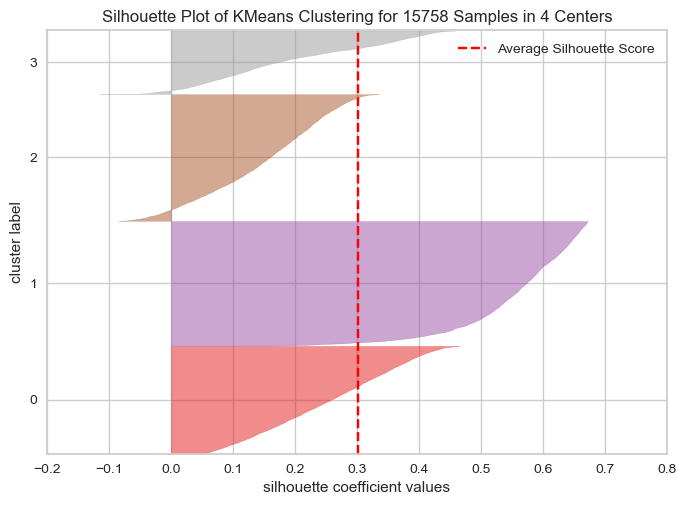

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 15758 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [21]:
# silhouette score method
sil_visualizer = SilhouetteVisualizer(KMeans(n_clusters=4, random_state=1234))
sil_visualizer.fit(X_prep)
sil_visualizer.show()

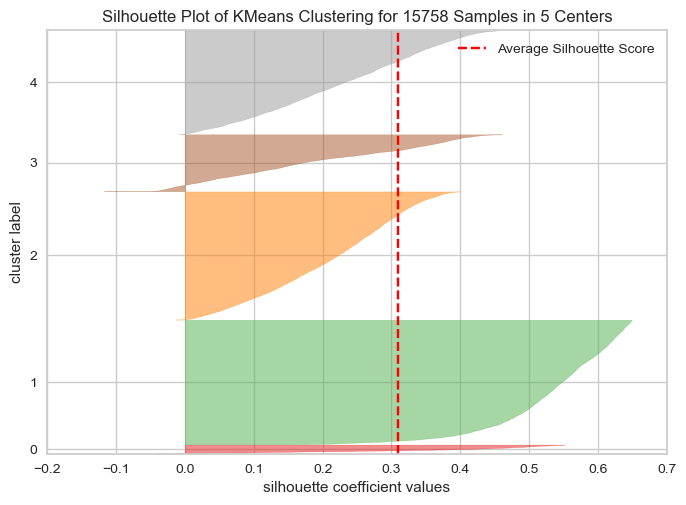

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 15758 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [22]:
# silhouette score method
sil_visualizer = SilhouetteVisualizer(KMeans(n_clusters=5, random_state=1234))
sil_visualizer.fit(X_prep)
sil_visualizer.show()

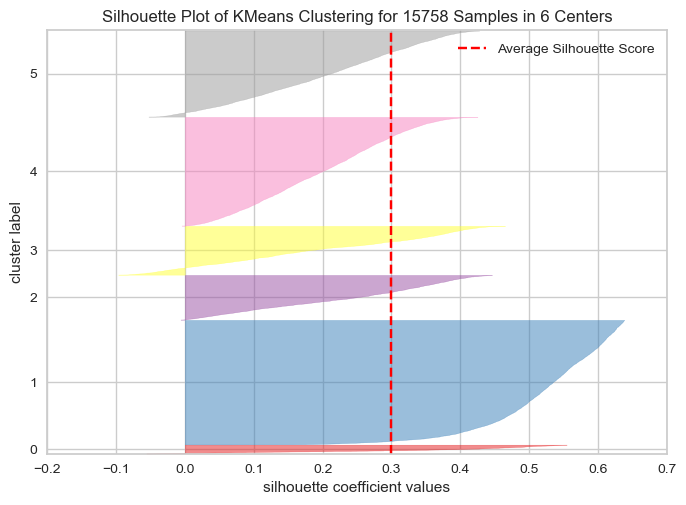

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 15758 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [23]:
# silhouette score method
sil_visualizer = SilhouetteVisualizer(KMeans(n_clusters=6, random_state=1234))
sil_visualizer.fit(X_prep)
sil_visualizer.show()

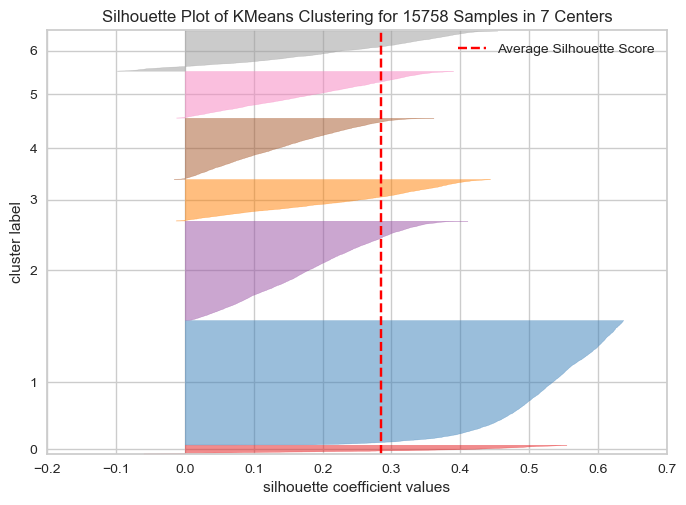

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 15758 Samples in 7 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [24]:
# silhouette score method
sil_visualizer = SilhouetteVisualizer(KMeans(n_clusters=7, random_state=1234))
sil_visualizer.fit(X_prep)
sil_visualizer.show()

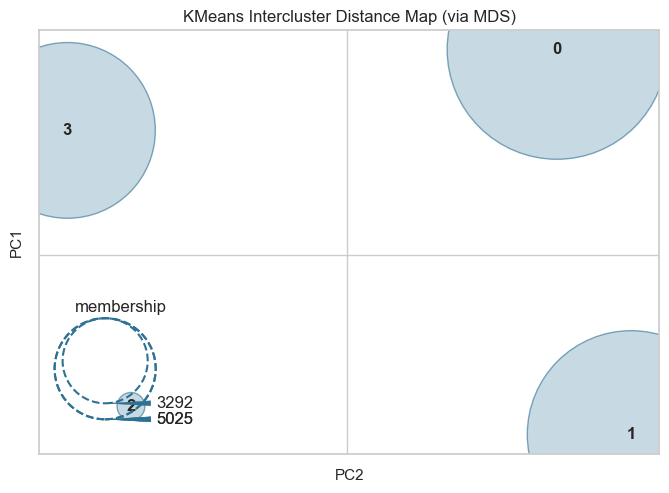

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [25]:
visualizer = InterclusterDistance(KMeans(n_clusters=4))
visualizer.fit(X_prep)
visualizer.show()

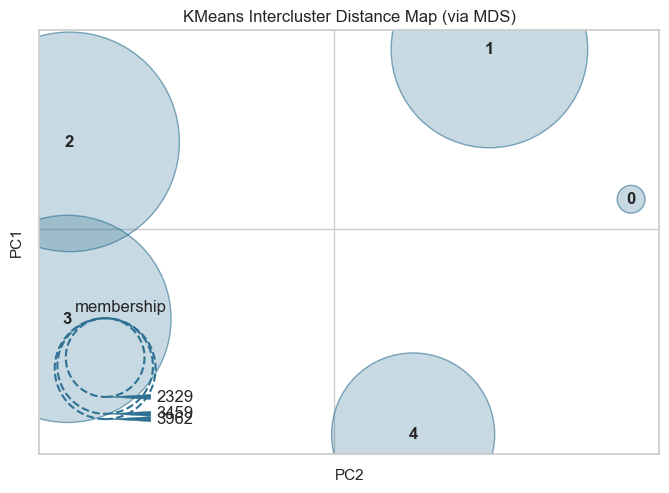

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [26]:
visualizer = InterclusterDistance(KMeans(n_clusters=5))
visualizer.fit(X_prep)
visualizer.show()

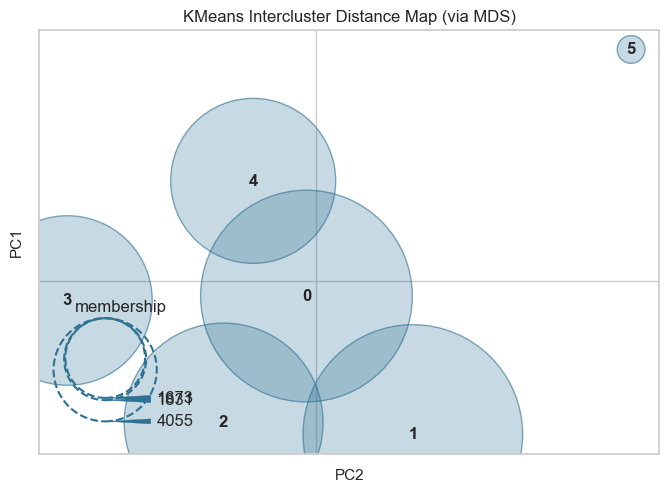

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [27]:
visualizer = InterclusterDistance(KMeans(n_clusters=6))
visualizer.fit(X_prep)
visualizer.show()

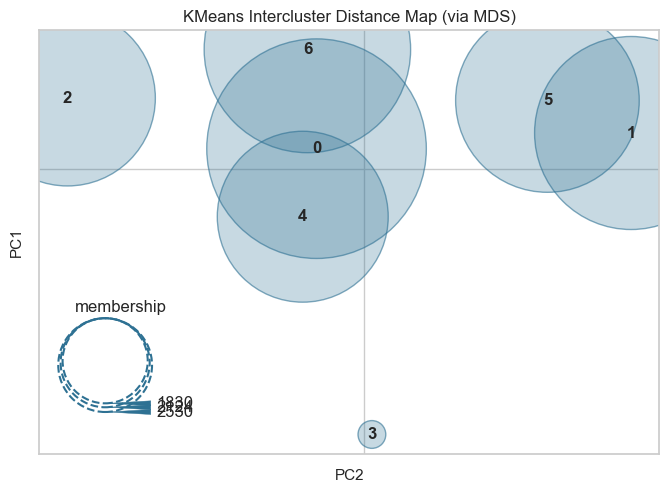

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [28]:
visualizer = InterclusterDistance(KMeans(n_clusters=7))
visualizer.fit(X_prep)
visualizer.show()

In [29]:
# Adding cluster label to dataframes
df2["cluster"] = kmeans7.labels_
numericals["cluster"] = kmeans7.labels_

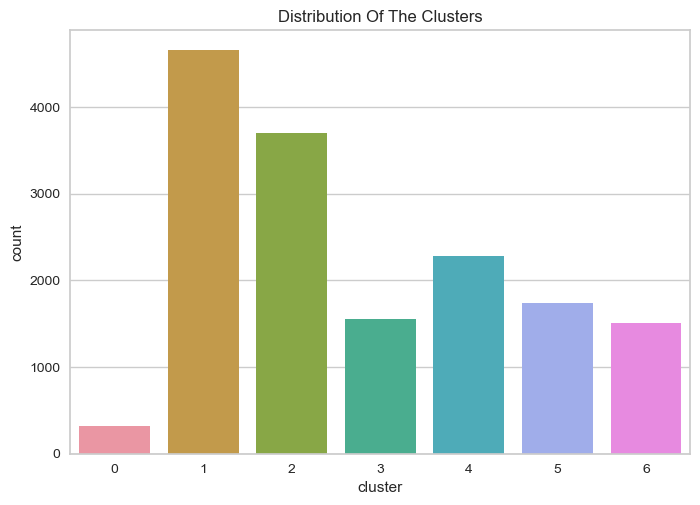

In [30]:
plot = sns.countplot(x=numericals["cluster"])
plot.set_title("Distribution Of The Clusters")
plt.show()

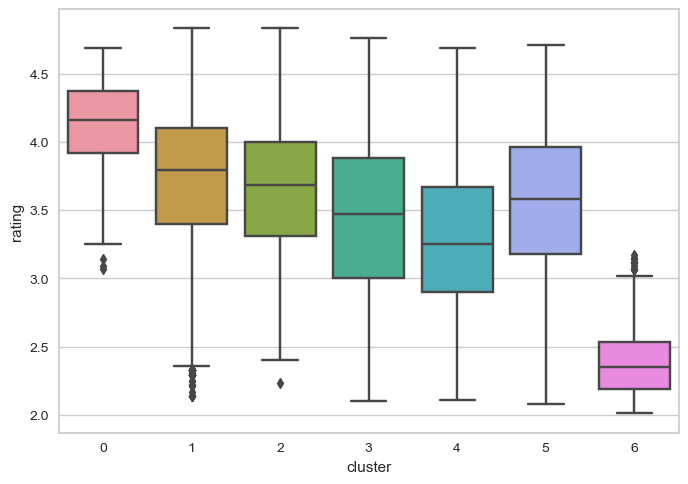

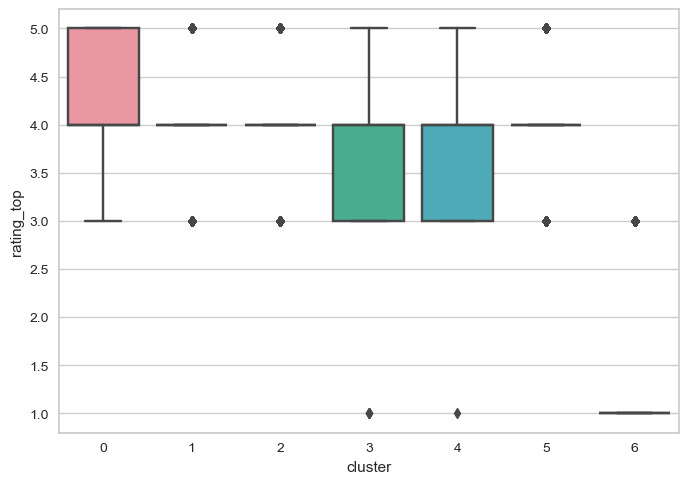

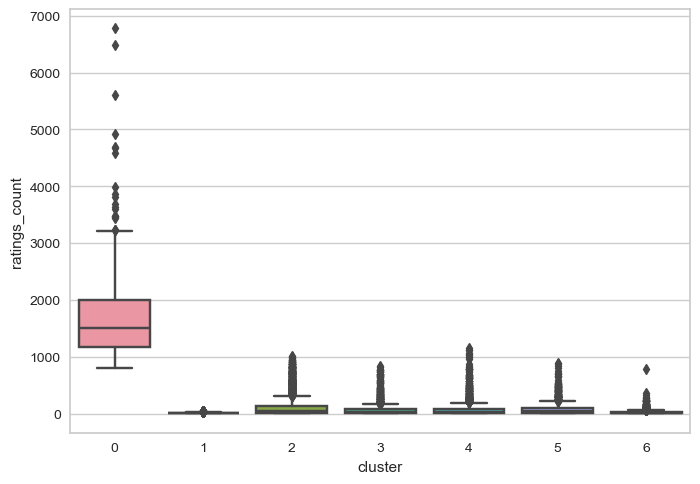

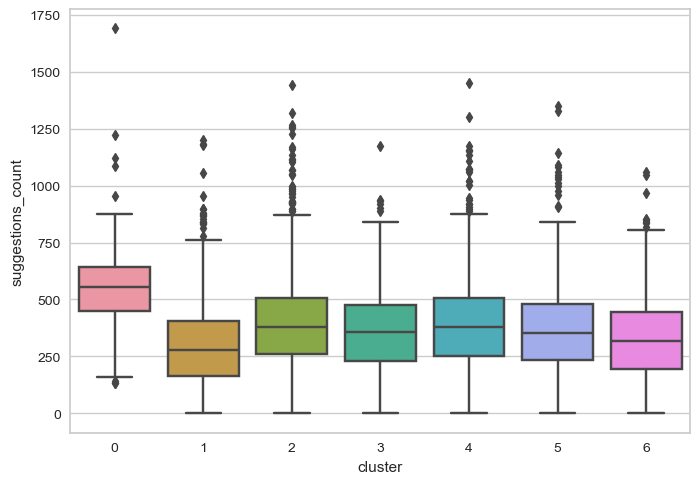

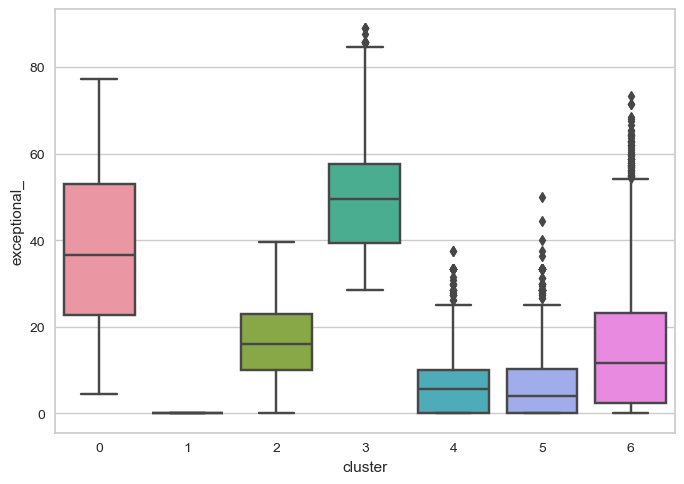

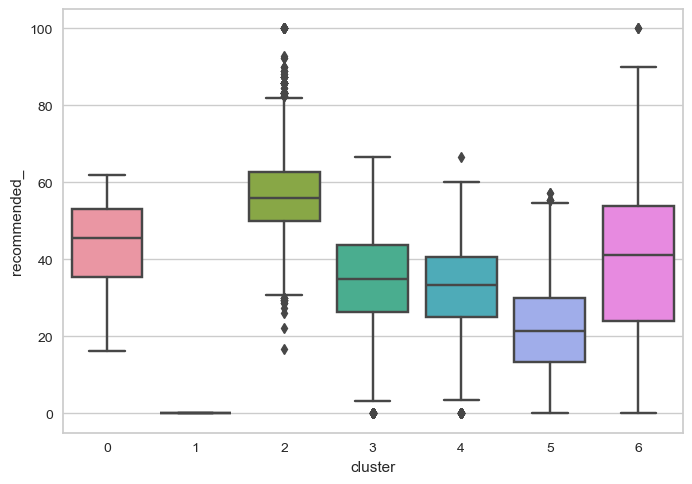

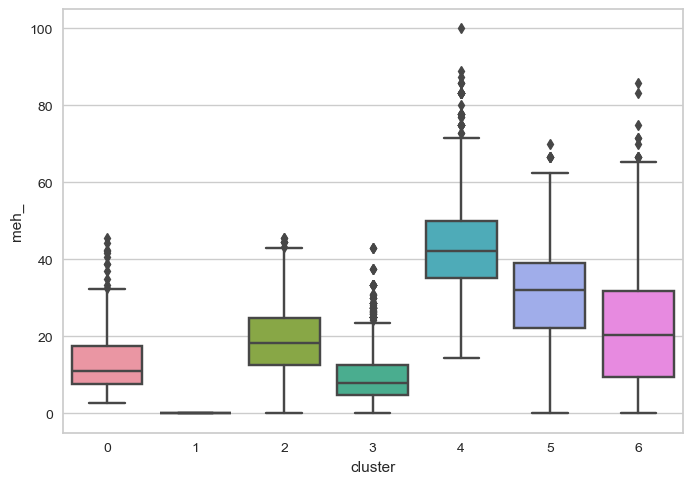

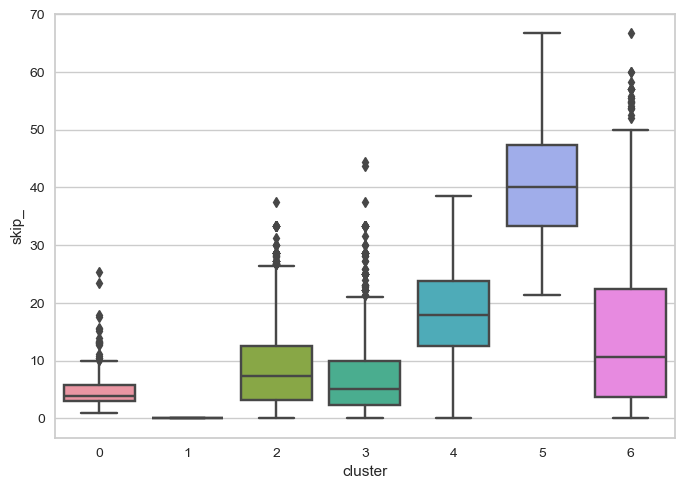

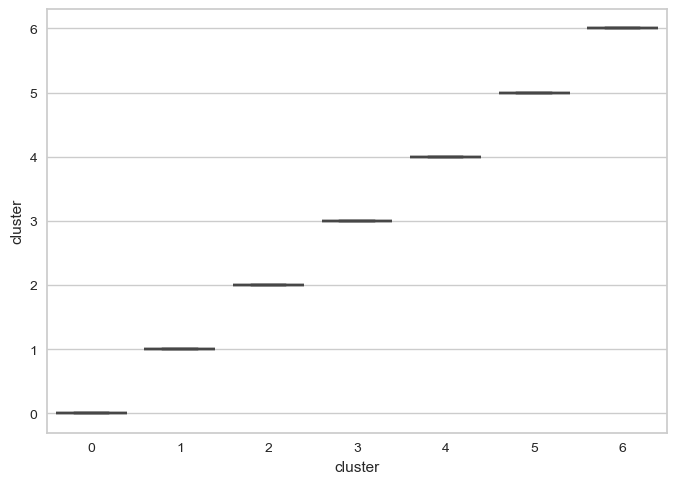

In [31]:
for col in numericals:
    sns.boxplot(x = 'cluster', y = col, data=numericals)
    plt.show()

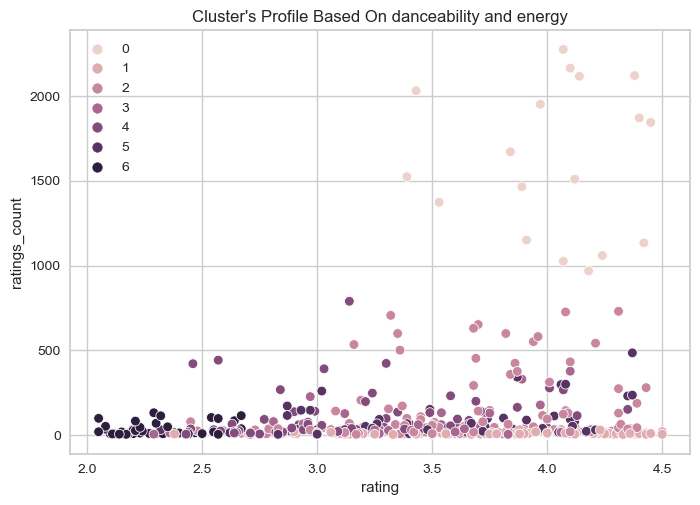

In [32]:
pl = sns.scatterplot(x="rating", y="ratings_count", hue="cluster", data =numericals.sample(500))
pl.set_title("Cluster's Profile Based On danceability and energy")
plt.legend()
plt.show()

In [33]:
# Export dataframe
df2.to_csv("15759_games_clean_formatted_CLUSTERED.csv")

In [34]:
# Save kmeans model
joblib.dump(kmeans7, "15759_games_kmean7.sav")

['15759_games_kmean7.sav']

In [35]:
# Ranking system implementation for each cluster
df = pd.read_csv("15759_games_clean_formatted_CLUSTERED.csv")
df.drop(["Unnamed: 0"], axis=1, inplace=True)
df["name"] = df["name"].apply(lambda x: x.lower())
df["released"] = pd.to_datetime(df['released'])

In [36]:
# Ranking
def calculate_ranking_score(df, gravity=1.8):
    """Calculates the ranking score for items in a DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        gravity (float, optional): Gravity constant. Defaults to 1.8.
    """

    df['ranking_score'] = (df["rating"] - 1) / ((pd.Timestamp.now() - df["released"]).dt.total_seconds() / 3600 + 2) ** gravity
    return df


In [37]:
# Extract every cluster into individual dataframes and calculate the ranking for each cluster invdividually
cluster_df_list = []
for i in range(0,7):
    data = df[df["cluster"] == i]
    data = calculate_ranking_score(data)
    cluster_df_list.append(data)

In [66]:
# Checking clustered dataframes for nans in the ranking column
for df in cluster_df_list:
    # Unique cluster values
    unique_clusters = df["cluster"].unique() 
    print("-------------------------------------------------")
    print(f"Cluster: {unique_clusters[0]}")
    # Columns with NaNs and their counts
    for col in df.columns:
        if col != "background_image":
            nan_count = df[col].isna().sum()  
            if nan_count > 0:
                print(f"Column '{col}': {nan_count} NaN values")
            

-------------------------------------------------
Cluster: 0
-------------------------------------------------
Cluster: 1
-------------------------------------------------
Cluster: 2
Column 'ranking_score': 8 NaN values
-------------------------------------------------
Cluster: 3
-------------------------------------------------
Cluster: 4
Column 'ranking_score': 2 NaN values
-------------------------------------------------
Cluster: 5
Column 'ranking_score': 4 NaN values
-------------------------------------------------
Cluster: 6


In [68]:
from sklearn.impute import SimpleImputer
# Using SimpleInputer to replace nan values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

clusters_to_fill_nan = [cluster_df_list[2], cluster_df_list[4], cluster_df_list[5]]

for cluster in clusters_to_fill_nan:
    cluster['ranking_score'] = imputer.fit_transform(cluster[['ranking_score']])

In [74]:
# For simplicity, assigning each member of the list to a variable
cluster_0_df = cluster_df_list[0]
cluster_1_df = cluster_df_list[1]
cluster_2_df = cluster_df_list[2]
cluster_3_df = cluster_df_list[3]
cluster_4_df = cluster_df_list[4]
cluster_5_df = cluster_df_list[5]
cluster_6_df = cluster_df_list[6]

In [75]:
cluster_2_df.sort_values(by=["ranking_score"], ascending=False)

,name,released,background_image,rating,rating_top,ratings_count,playtime,suggestions_count,reviews_count,platform_name_0,platform_name_1,platform_name_2,platform_name_3,platform_name_4,platform_name_5,platform_name_6,genre_0,genre_1,tags_extracted,exceptional_,recommended_,meh_,skip_,cluster,ranking_score
7089,alone in the dark,2024-03-20,https://media.rawg.io/media/screenshots/719/71...,3.33,3.0,27.0,0.0,393.0,27.0,PlayStation 4,Xbox One,Nintendo Switch,PC,macOS,undefined,undefined,Adventure,Simulation,['Singleplayer'],27.27,54.55,9.09,9.09,2,1.706071e-05
10730,balatro,2024-02-20,https://media.rawg.io/media/screenshots/00f/00...,4.48,5.0,19.0,4.0,269.0,21.0,GameCube,PlayStation 2,Xbox,PC,undefined,undefined,undefined,Simulation,Racing,['Singleplayer'],11.11,55.56,22.22,11.11,2,7.475528e-06
7294,pacific drive,2024-02-21,https://media.rawg.io/media/games/43e/43e69395...,3.66,4.0,26.0,6.0,221.0,29.0,SEGA Saturn,PlayStation,PC,3DO,undefined,undefined,undefined,Racing,Arcade,['Singleplayer'],30.00,61.11,8.89,0.00,2,5.893540e-06
8932,helldivers ii,2024-02-08,https://media.rawg.io/media/games/cbb/cbb94805...,4.36,5.0,24.0,0.0,302.0,25.0,PlayStation 4,Genesis,Wii,iOS,undefined,undefined,undefined,Action,Arcade,['Singleplayer'],21.74,60.87,13.04,4.35,2,5.164128e-06
9121,helldivers 2,2024-02-08,https://media.rawg.io/media/screenshots/d58/d5...,4.00,5.0,14.0,6.0,0.0,15.0,Commodore / Amiga,PC,Atari ST,SEGA Saturn,SEGA Master System,Nintendo 3DS,Game Gear,Racing,undefined,['Multiplayer'],15.62,59.38,21.88,3.12,2,4.610828e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7623,track & field,1983-01-01,https://media.rawg.io/media/screenshots/302/30...,3.47,4.0,51.0,0.0,412.0,51.0,Xbox One,PlayStation 4,PC,undefined,undefined,undefined,undefined,RPG,undefined,"['Singleplayer', 'Multiplayer']",22.86,48.57,20.00,8.57,2,2.437825e-10
8624,galaxian,1979-01-01,https://media.rawg.io/media/games/07c/07c5bb43...,3.87,4.0,76.0,0.0,180.0,76.0,Nintendo Switch,Xbox One,PlayStation 4,PC,undefined,undefined,undefined,Action,Simulation,['Singleplayer'],19.05,47.62,9.52,23.81,2,2.398367e-10
9084,space invaders (1978),1978-06-01,https://media.rawg.io/media/screenshots/c38/c3...,3.77,4.0,69.0,0.0,191.0,69.0,PC,iOS,Android,undefined,undefined,undefined,undefined,Action,Arcade,"['Singleplayer', 'Multiplayer']",5.13,56.41,30.77,7.69,2,2.261866e-10
8020,joust,1982-07-16,https://media.rawg.io/media/screenshots/565/56...,3.03,3.0,29.0,0.0,183.0,29.0,PC,undefined,undefined,undefined,undefined,undefined,undefined,RPG,Strategy,"['Singleplayer', 'Multiplayer']",11.11,62.96,14.81,11.11,2,1.963775e-10


In [76]:
combined_df = pd.concat([cluster_0_df,cluster_1_df,cluster_2_df,cluster_3_df,cluster_4_df,cluster_5_df,cluster_6_df])
combined_df

,name,released,background_image,rating,rating_top,ratings_count,playtime,suggestions_count,reviews_count,platform_name_0,platform_name_1,platform_name_2,platform_name_3,platform_name_4,platform_name_5,platform_name_6,genre_0,genre_1,tags_extracted,exceptional_,recommended_,meh_,skip_,cluster,ranking_score
0,grand theft auto v,2013-09-17,https://media.rawg.io/media/games/20a/20aa03a1...,4.47,5.0,6777.0,74.0,431.0,6878.0,PC,PlayStation 5,Xbox Series S/X,PlayStation 4,PlayStation 3,Xbox 360,Xbox One,Action,undefined,"['Singleplayer', 'Multiplayer']",58.99,32.83,6.35,1.83,0,3.969504e-09
1,the witcher 3: wild hunt,2015-05-18,https://media.rawg.io/media/games/618/618c2031...,4.65,5.0,6489.0,45.0,675.0,6595.0,Xbox Series S/X,PlayStation 5,macOS,PlayStation 4,Nintendo Switch,PC,Xbox One,Action,RPG,['Singleplayer'],77.15,16.12,4.20,2.53,0,5.681102e-09
2,portal 2,2011-04-18,https://media.rawg.io/media/games/2ba/2bac0e87...,4.61,5.0,5615.0,11.0,550.0,5668.0,PlayStation 3,PC,Xbox 360,Linux,macOS,Xbox One,undefined,Shooter,Puzzle,"['Singleplayer', 'Multiplayer']",70.15,24.95,2.70,2.21,0,2.851857e-09
3,counter-strike: global offensive,2012-08-21,https://media.rawg.io/media/games/736/73619bd3...,3.57,4.0,3443.0,65.0,587.0,3478.0,PC,Linux,Xbox 360,PlayStation 3,undefined,undefined,undefined,Shooter,undefined,['Multiplayer'],16.10,46.81,25.91,11.18,0,2.470894e-09
4,tomb raider (2013),2013-03-05,https://media.rawg.io/media/games/021/021c4e21...,4.05,4.0,3863.0,10.0,646.0,3892.0,PlayStation 4,macOS,PC,Xbox One,Xbox 360,PlayStation 3,undefined,Action,undefined,"['Singleplayer', 'Multiplayer']",25.49,60.53,10.92,3.06,0,3.191927e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15668,bus simulator: ultimate,2019-06-13,https://media.rawg.io/media/screenshots/5a5/5a...,2.67,1.0,7.0,0.0,225.0,9.0,undefined,undefined,undefined,undefined,undefined,undefined,undefined,undefined,undefined,['Singleplayer'],0.00,0.00,0.00,0.00,6,7.784552e-09
15683,world war ii combat: road to berlin,2006-01-23,https://media.rawg.io/media/screenshots/927/92...,2.33,1.0,6.0,0.0,429.0,6.0,undefined,undefined,undefined,undefined,undefined,undefined,undefined,undefined,undefined,['Singleplayer'],0.00,0.00,0.00,0.00,6,5.716570e-10
15708,syberia 3 - an automaton with a plan,2017-11-07,https://media.rawg.io/media/screenshots/987/98...,2.29,1.0,7.0,0.0,274.0,7.0,undefined,undefined,undefined,undefined,undefined,undefined,undefined,undefined,undefined,['Singleplayer'],0.00,0.00,0.00,0.00,6,3.603506e-09
15734,fatalzone,2023-10-23,https://media.rawg.io/media/screenshots/ed7/ed...,2.33,1.0,5.0,0.0,475.0,6.0,undefined,undefined,undefined,undefined,undefined,undefined,undefined,undefined,undefined,['Singleplayer'],0.00,0.00,0.00,0.00,6,3.851629e-07


In [77]:
combined_df.isna().sum()

name                  0
released              0
background_image     64
rating                0
rating_top            0
ratings_count         0
playtime              0
suggestions_count     0
reviews_count         0
platform_name_0       0
platform_name_1       0
platform_name_2       0
platform_name_3       0
platform_name_4       0
platform_name_5       0
platform_name_6       0
genre_0               0
genre_1               0
tags_extracted        0
exceptional_          0
recommended_          0
meh_                  0
skip_                 0
cluster               0
ranking_score         0
dtype: int64

In [78]:
#df_filtered = df.sort_values(by=['column1'], ascending=False)
# Export dataframe clustered and each cluster ranked
combined_df.to_csv("15759_games_clean_formatted_CLUSTERED_RANKED.csv")

In [80]:
from scipy import stats

# ANOVA
# Conduct a one-way ANOVA test for each feature. This compares mean values between the cluster groups.

numericals = combined_df.select_dtypes(include='number')
for col in numericals.columns:
    f_val, p_val = stats.f_oneway(*[combined_df[combined_df["cluster"] == c][col] for c in combined_df["cluster"].unique()])  
    print(f"{col}: F-value = {f_val:.3f}, p-value = {p_val:.4f}")

rating: F-value = 1752.892, p-value = 0.0000
rating_top: F-value = 4517.600, p-value = 0.0000
ratings_count: F-value = 5406.411, p-value = 0.0000
playtime: F-value = 17.780, p-value = 0.0000
suggestions_count: F-value = 202.085, p-value = 0.0000
reviews_count: F-value = 5399.614, p-value = 0.0000
exceptional_: F-value = 7079.520, p-value = 0.0000
recommended_: F-value = 9265.831, p-value = 0.0000
meh_: F-value = 6632.081, p-value = 0.0000
skip_: F-value = 7150.269, p-value = 0.0000
cluster: F-value = inf, p-value = 0.0000
ranking_score: F-value = 0.324, p-value = 0.9246


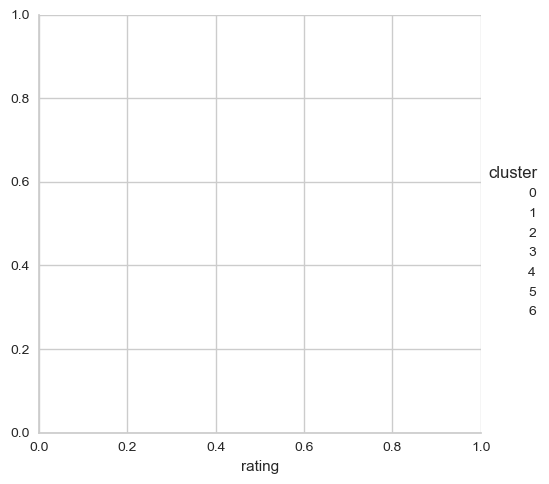

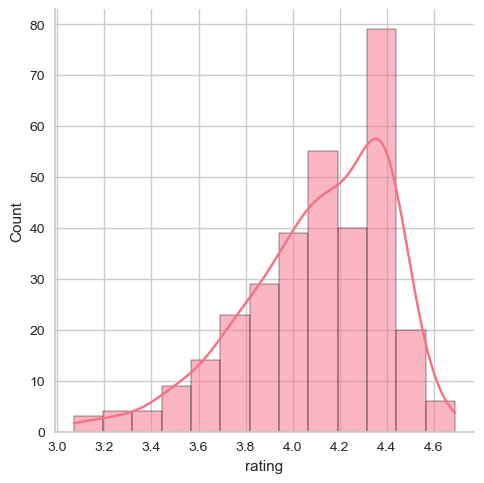

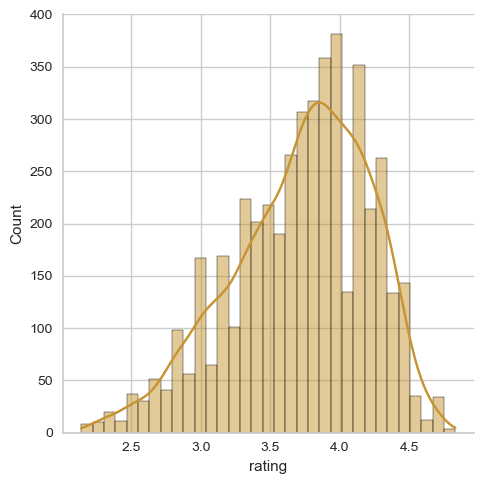

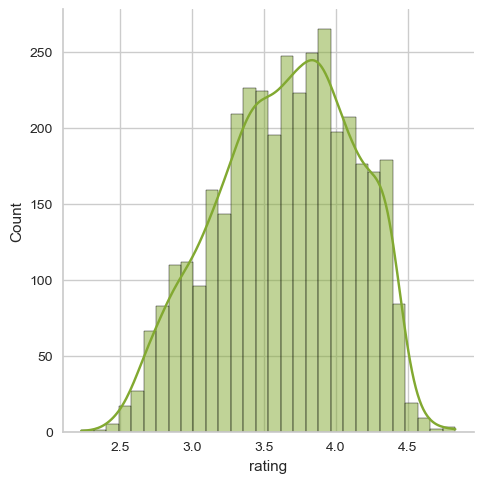

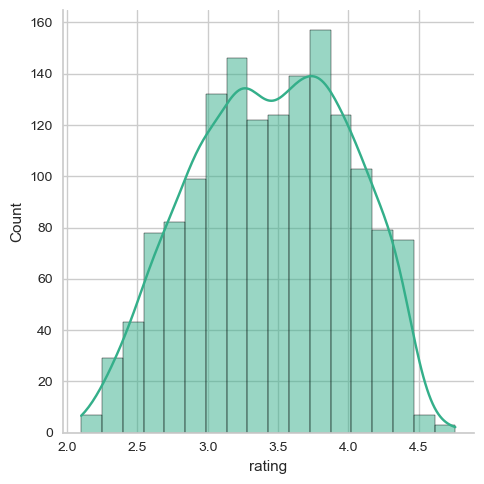

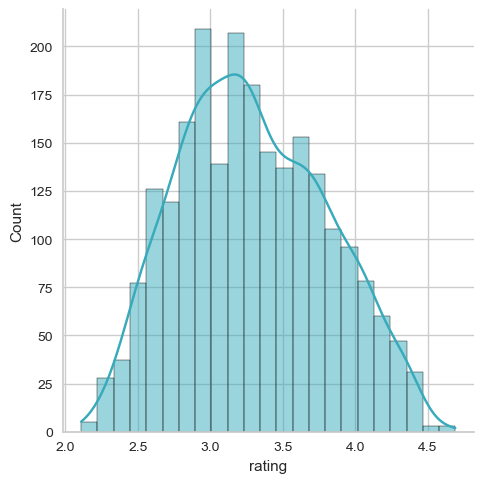

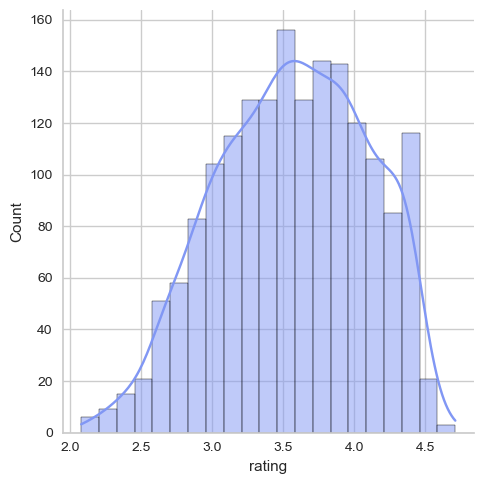

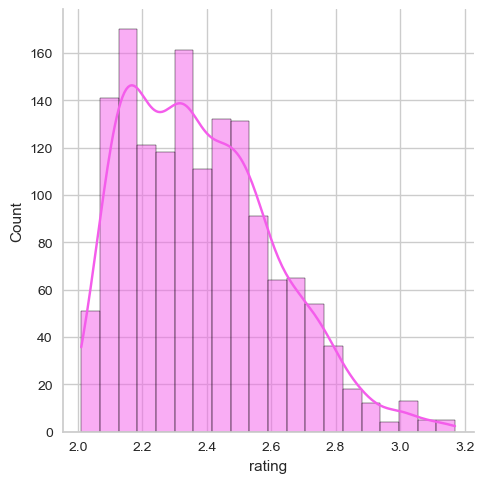

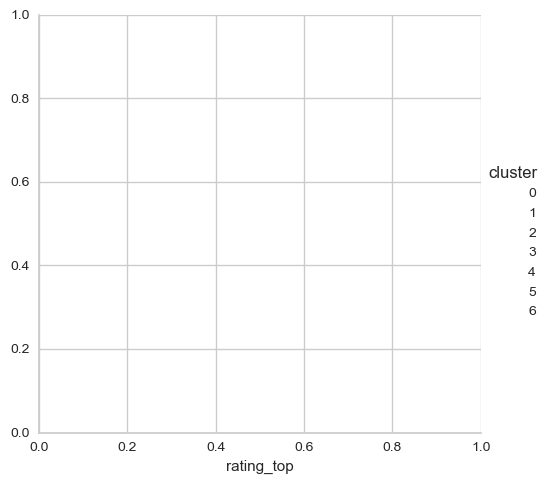

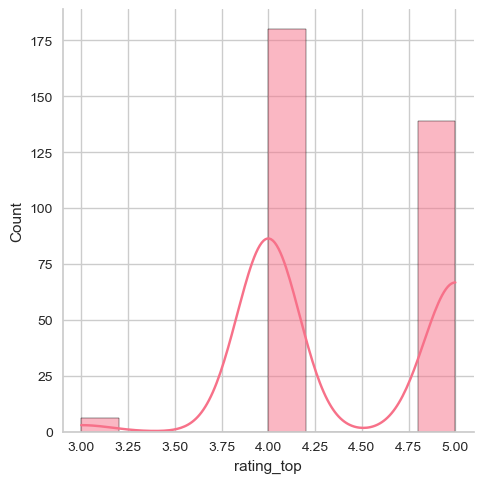

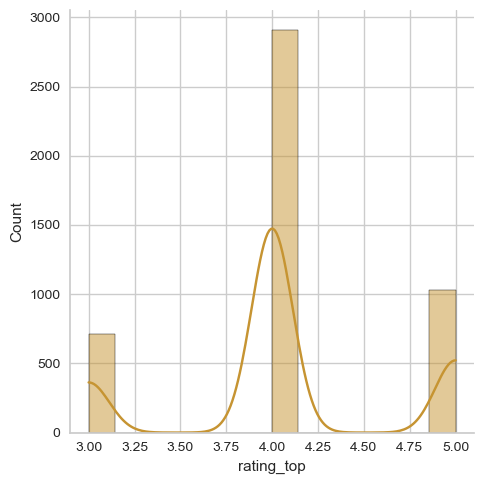

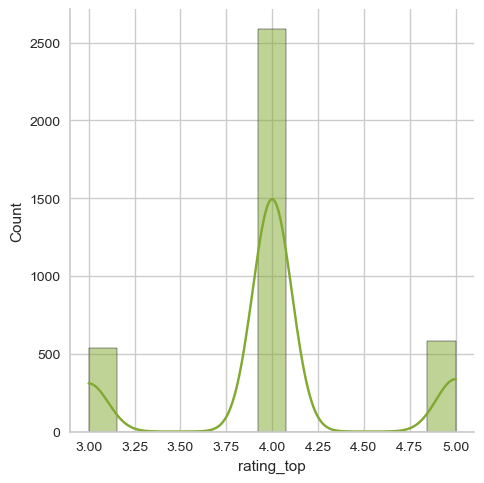

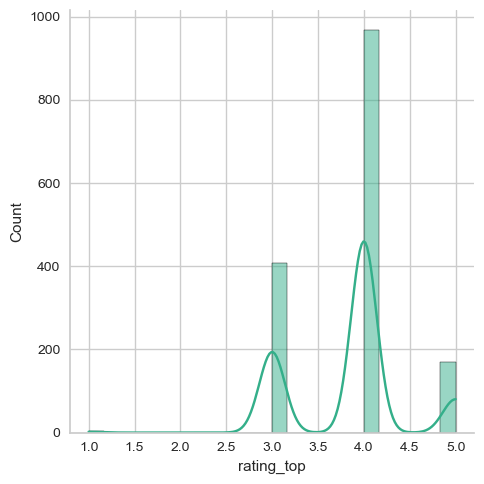

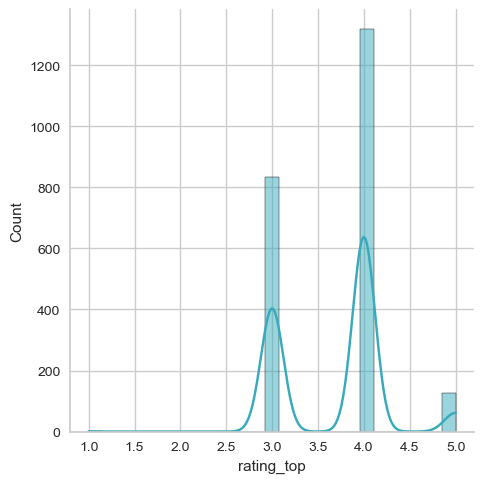

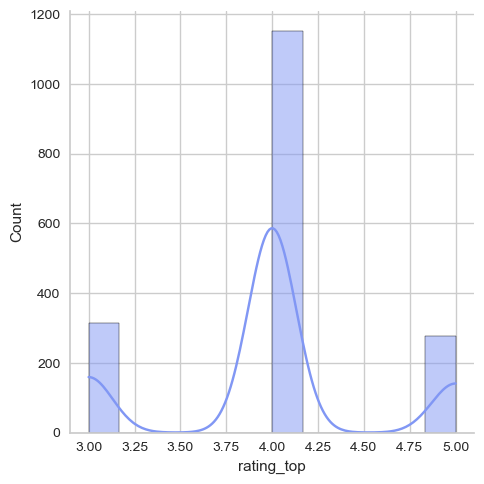

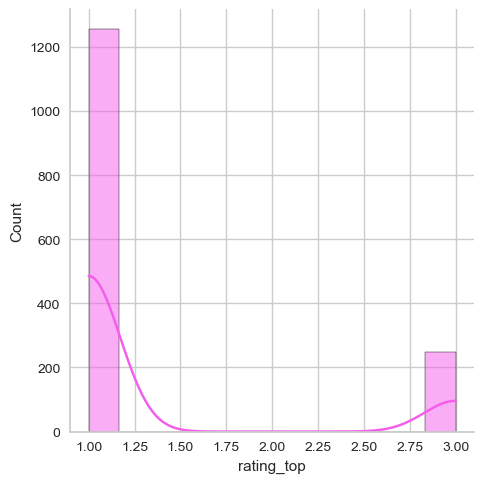

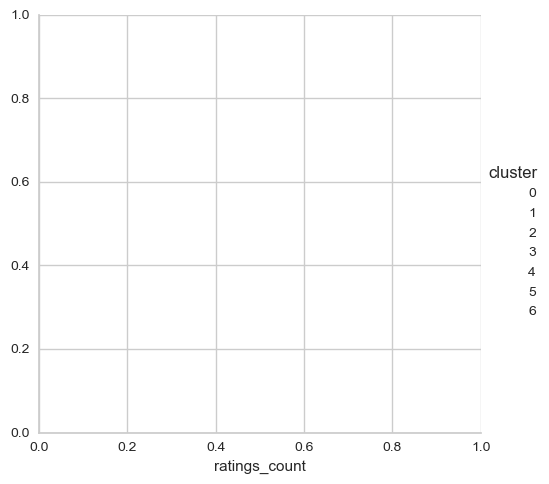

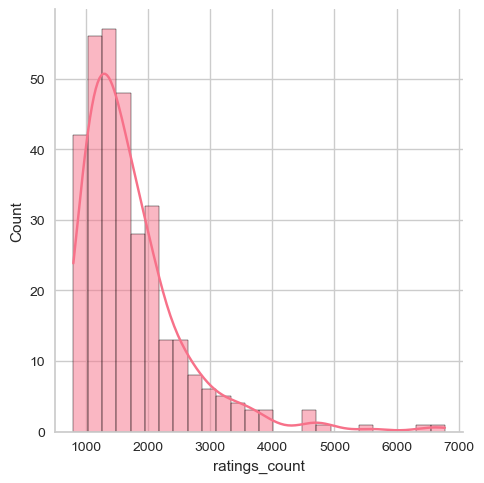

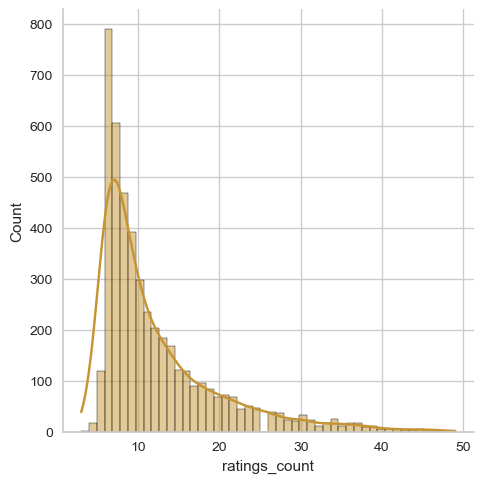

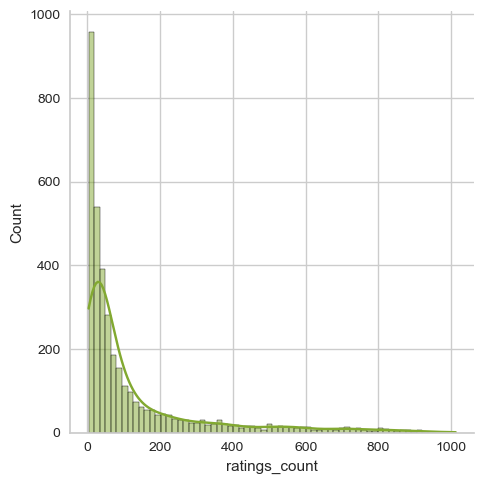

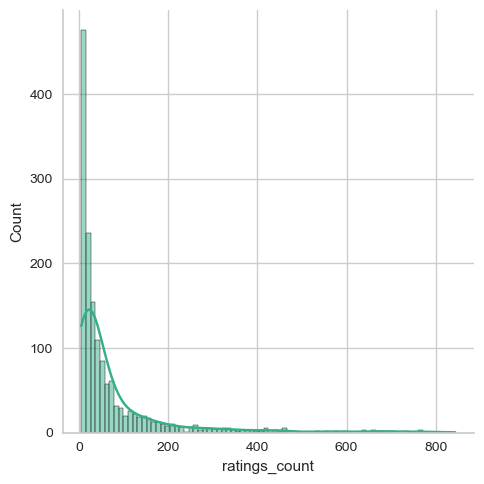

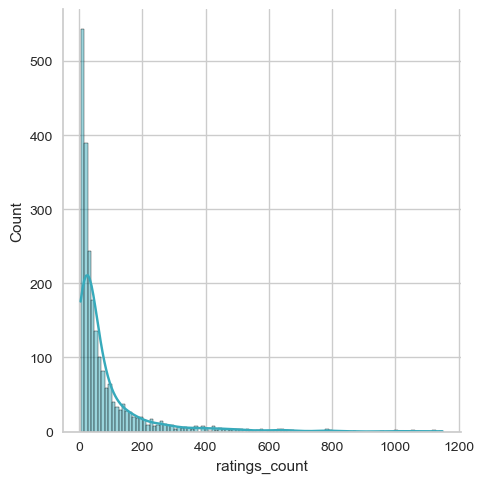

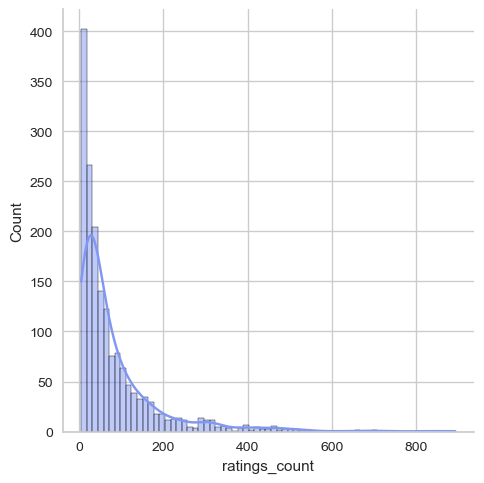

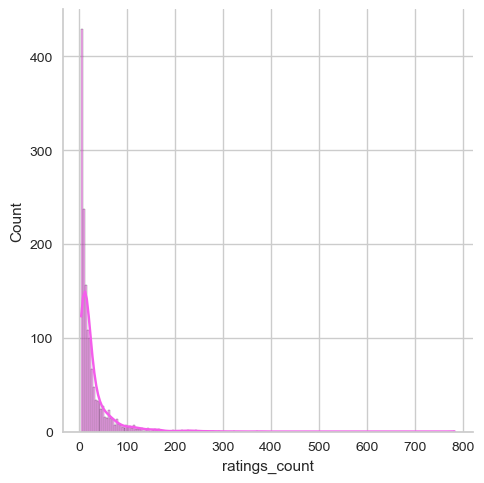

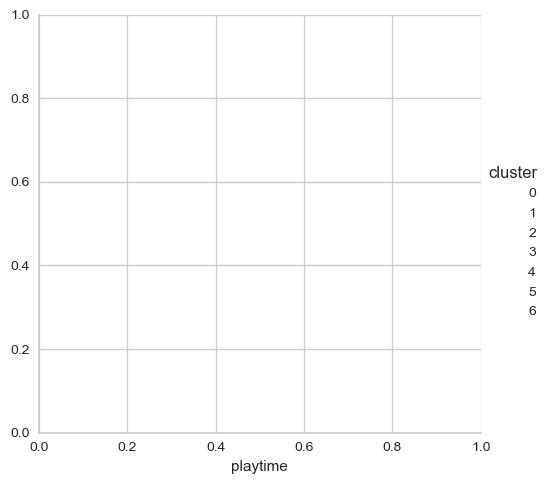

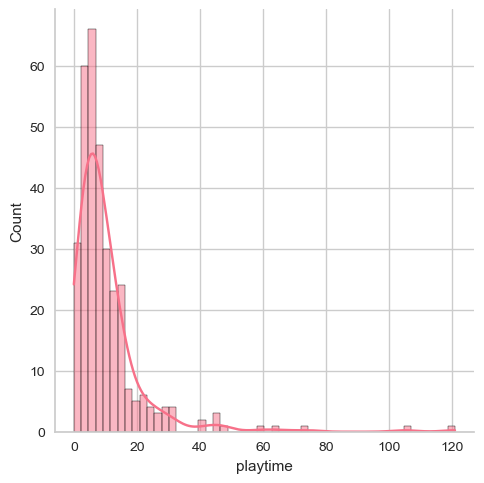

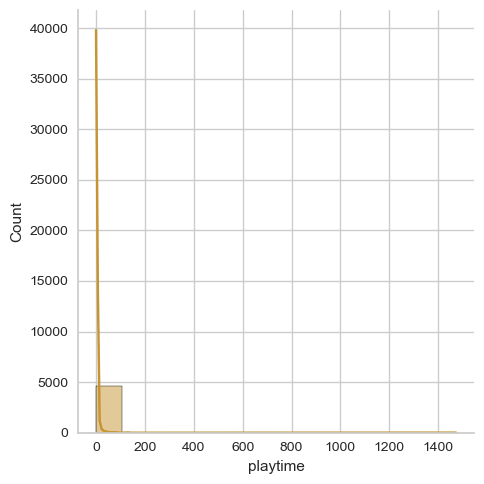

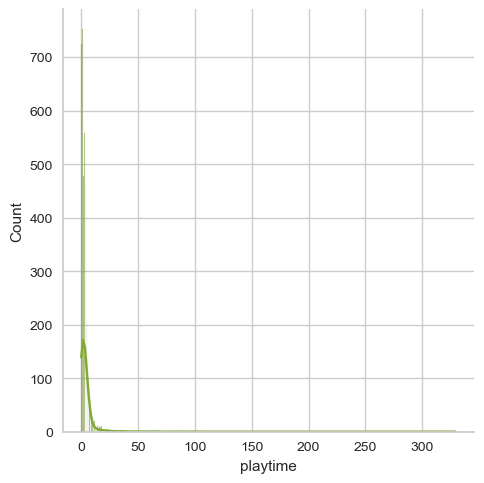

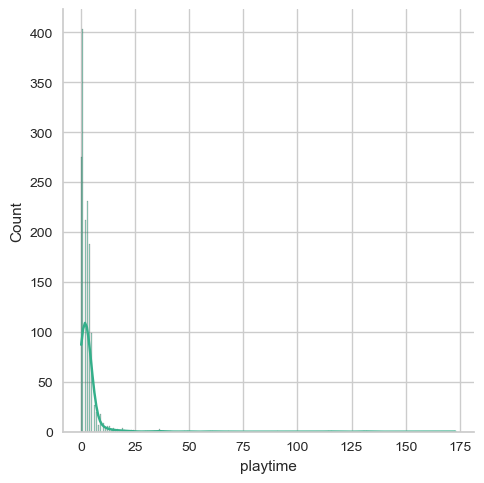

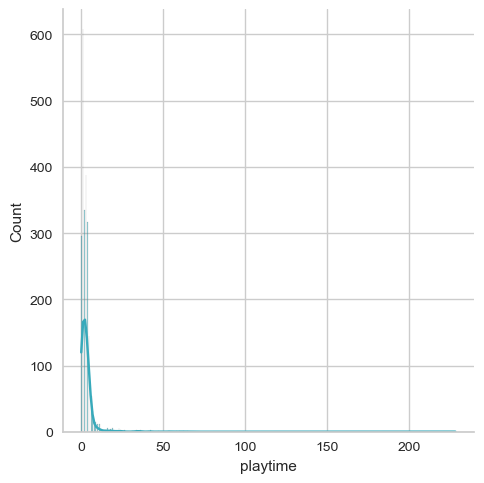

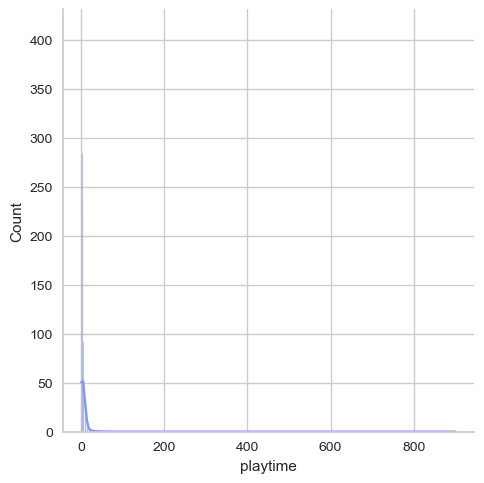

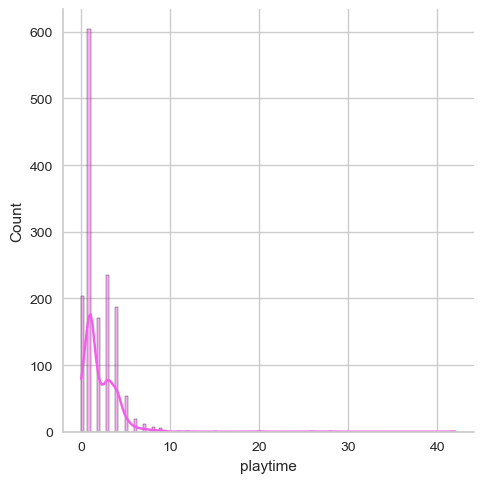

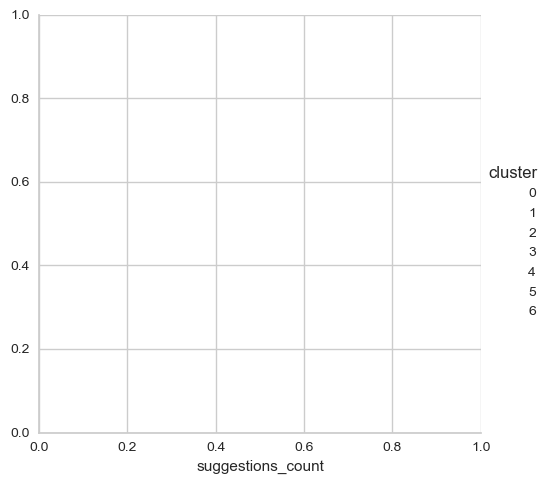

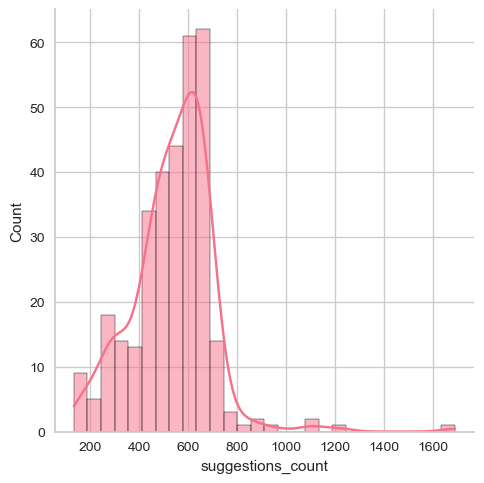

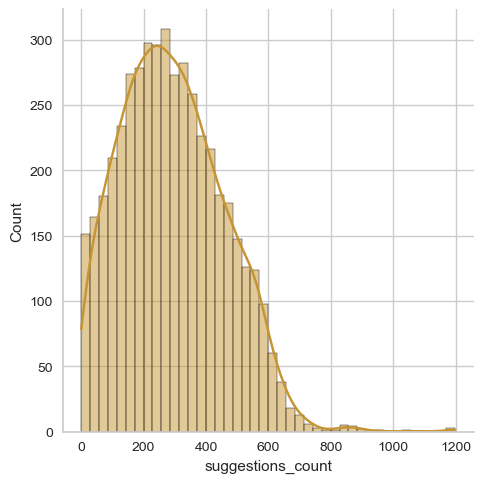

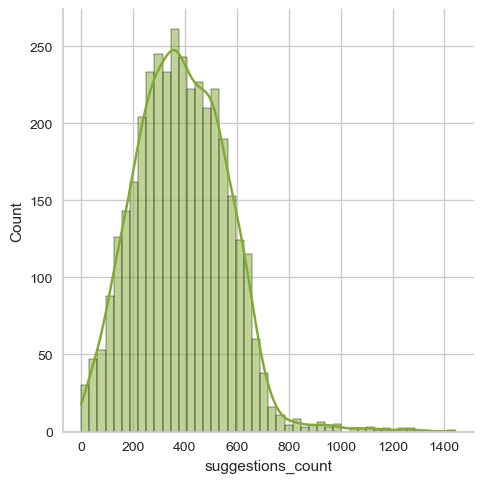

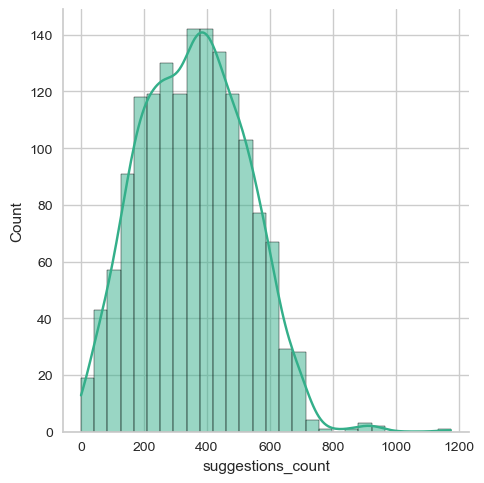

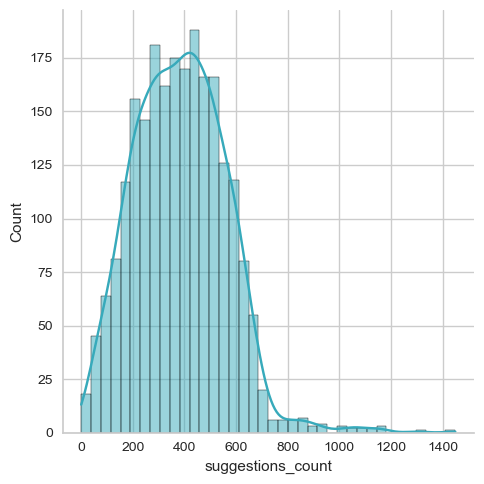

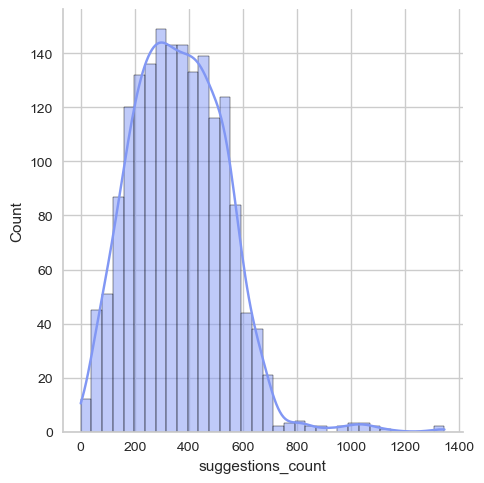

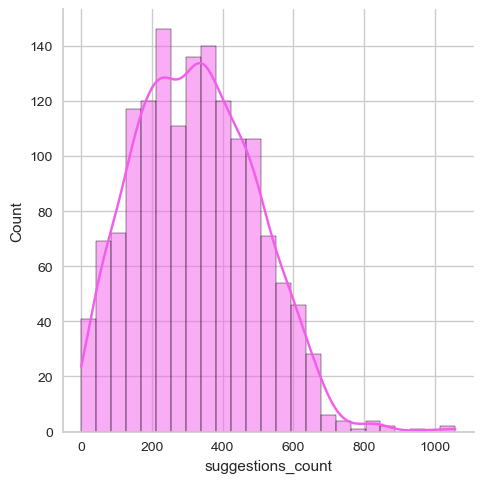

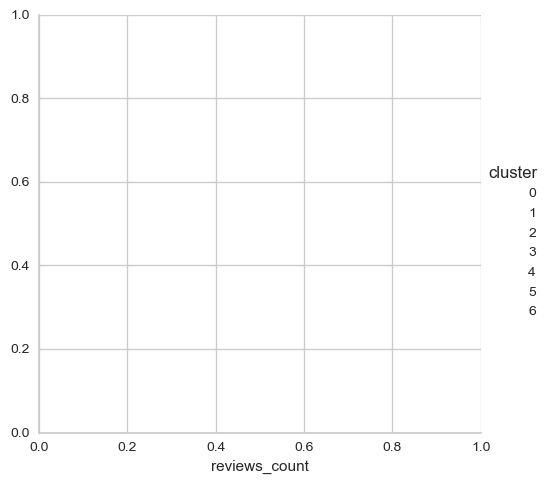

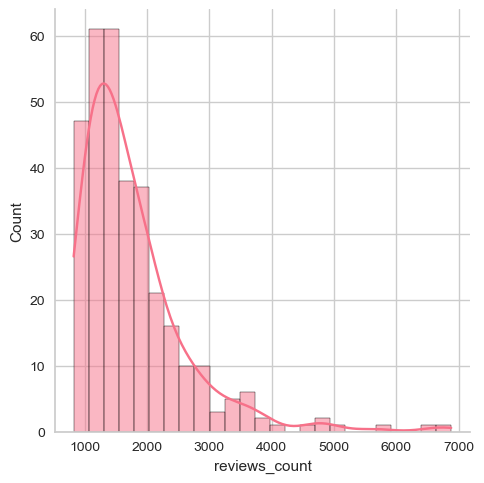

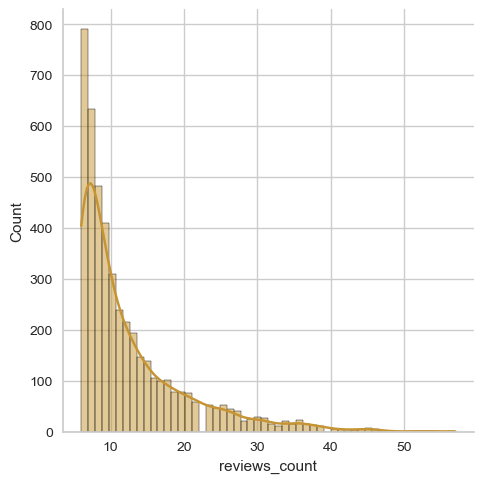

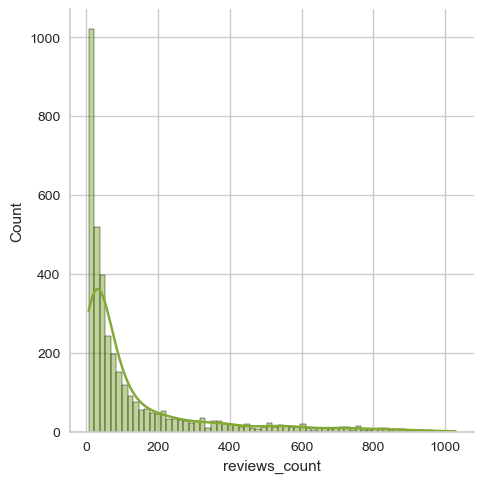

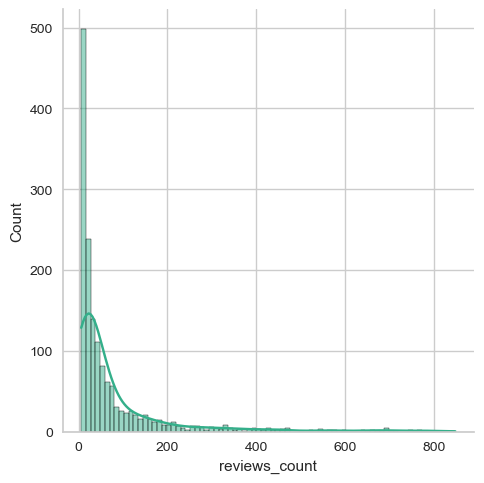

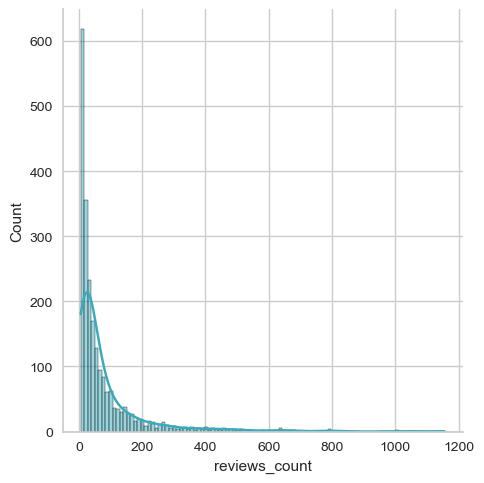

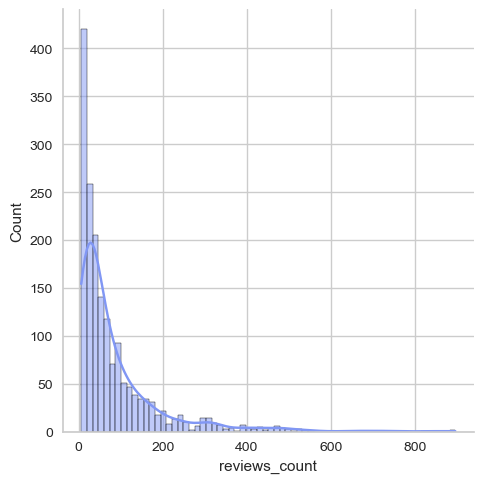

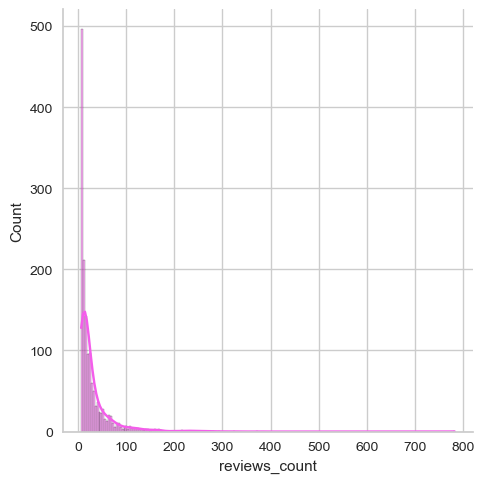

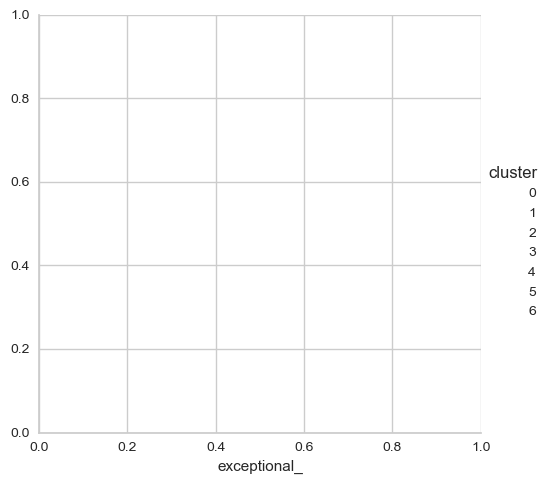

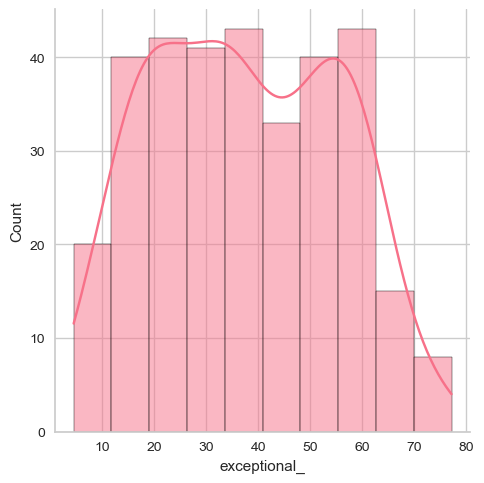

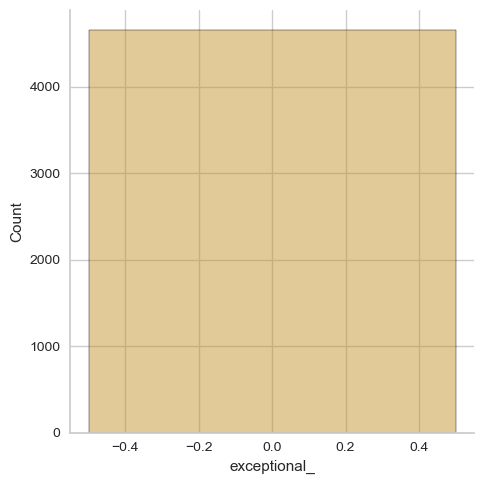

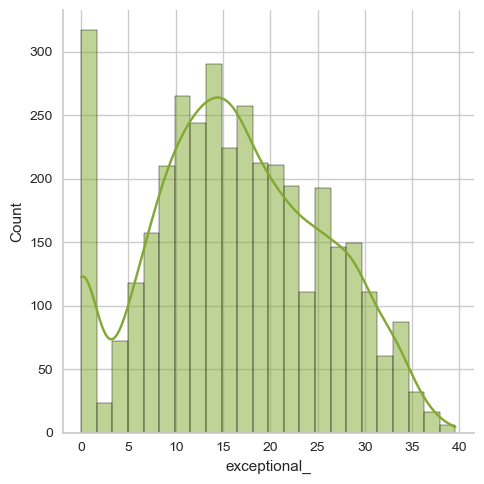

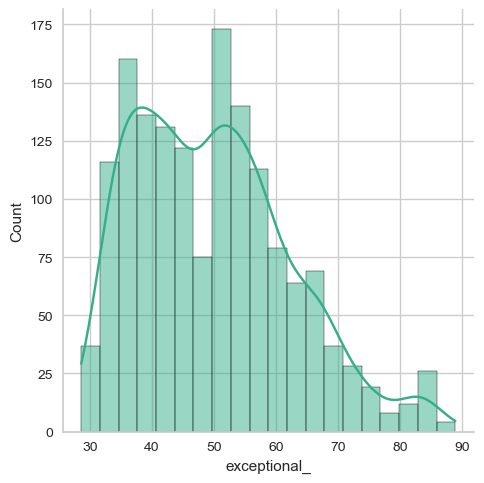

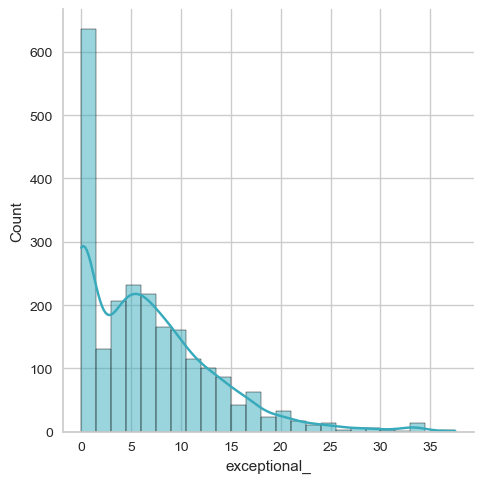

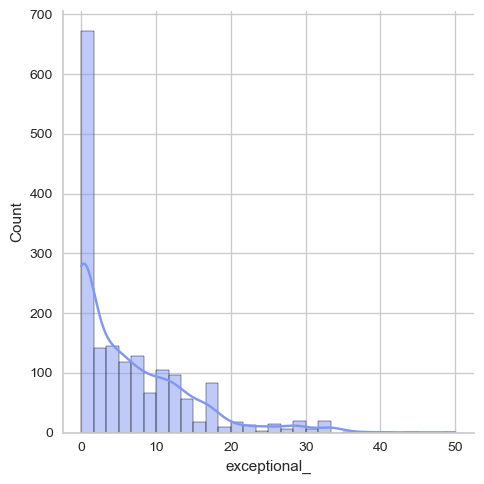

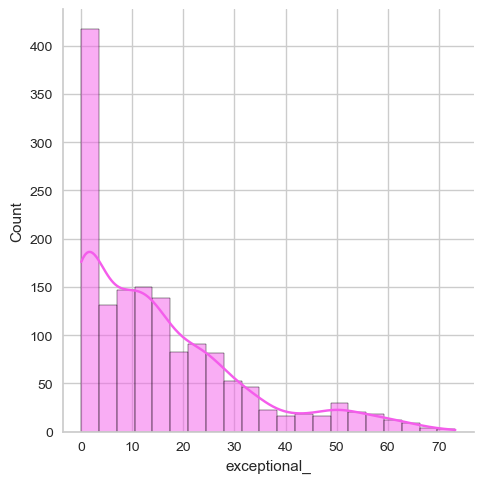

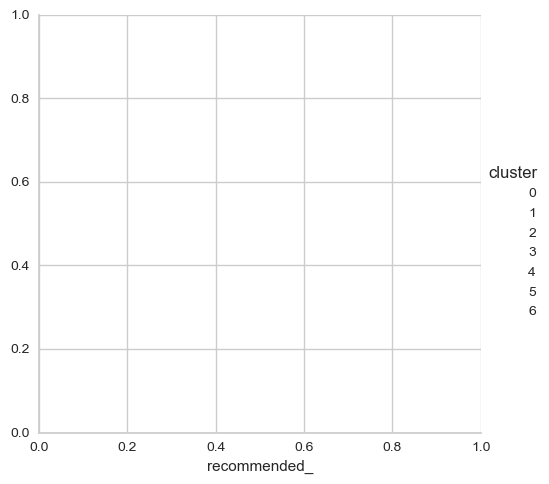

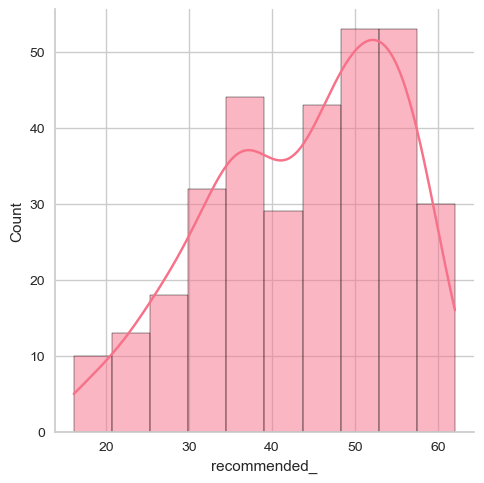

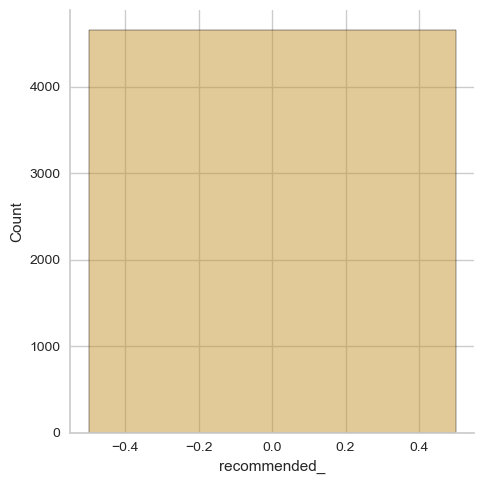

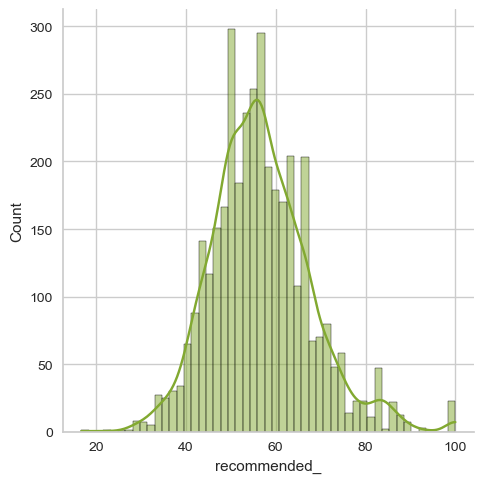

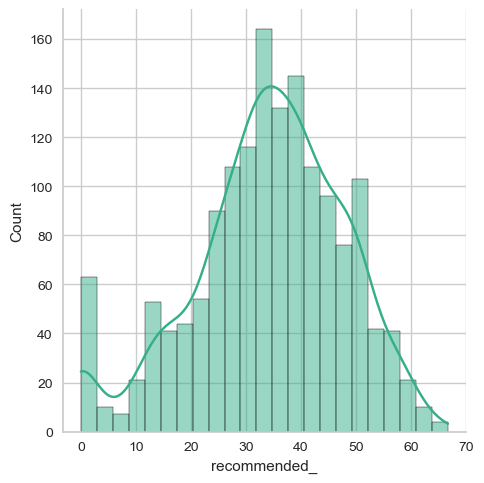

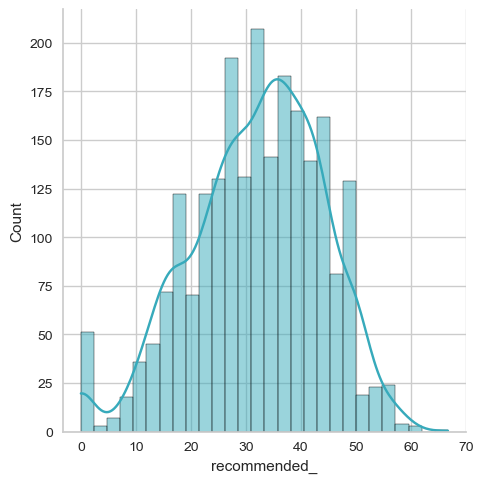

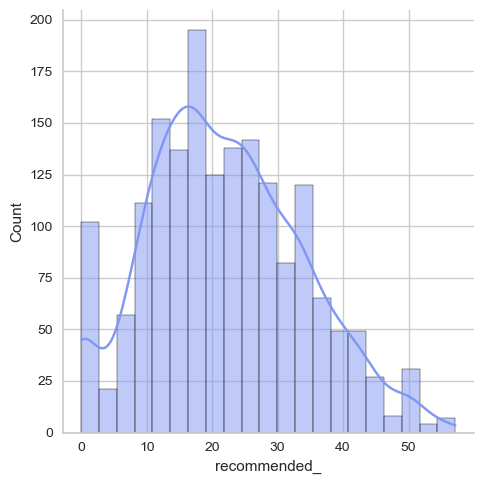

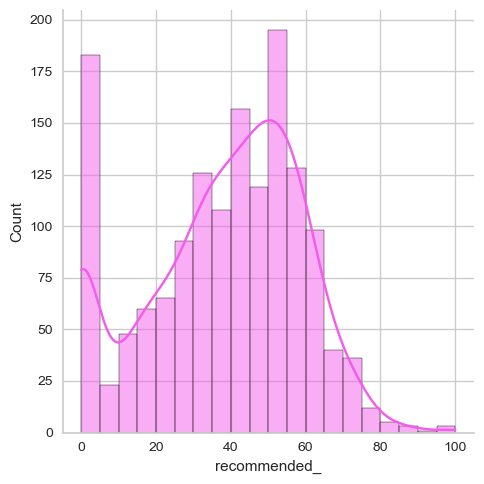

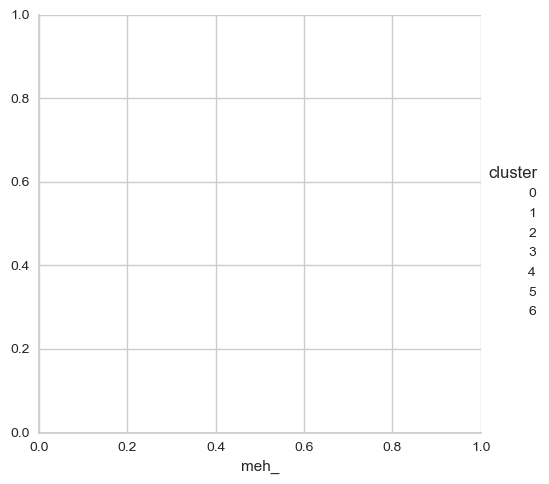

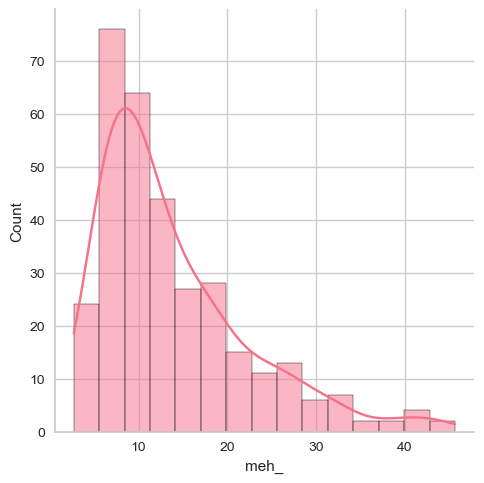

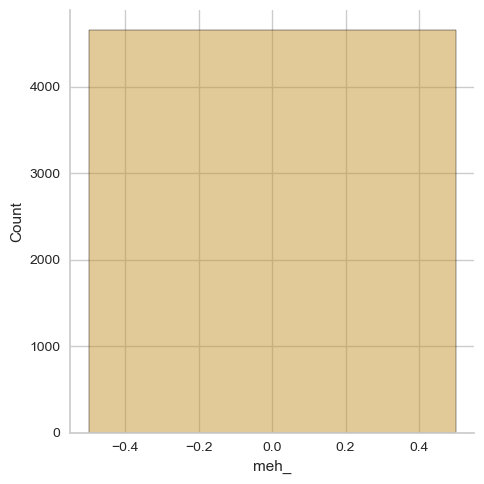

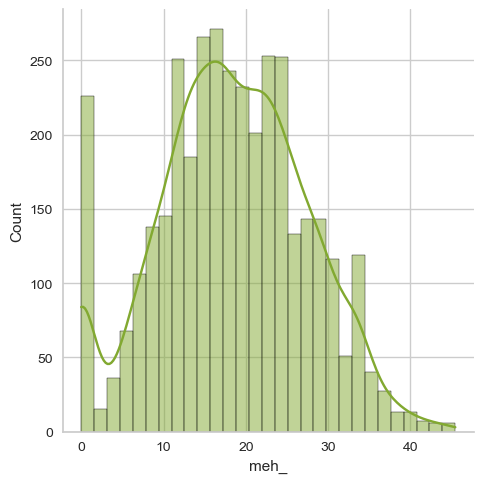

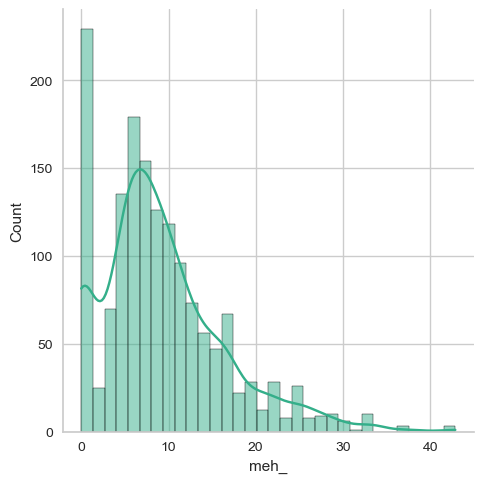

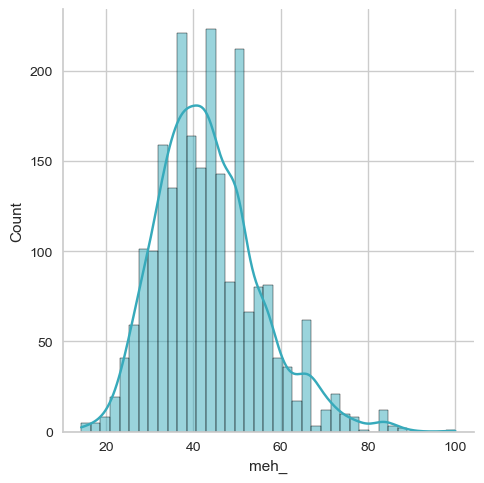

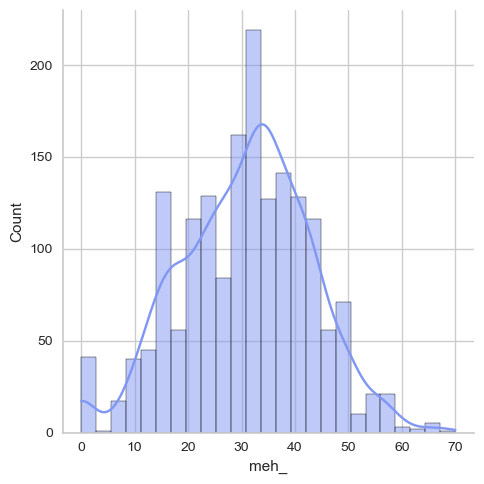

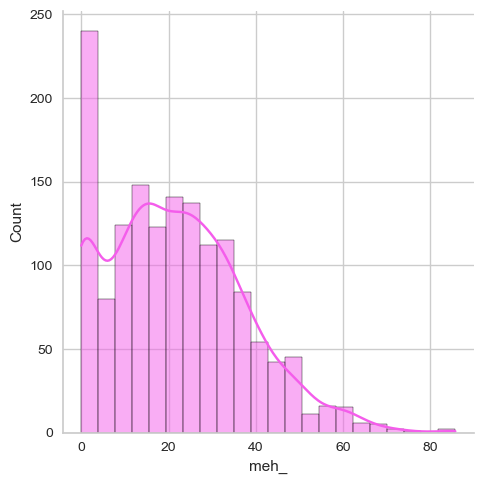

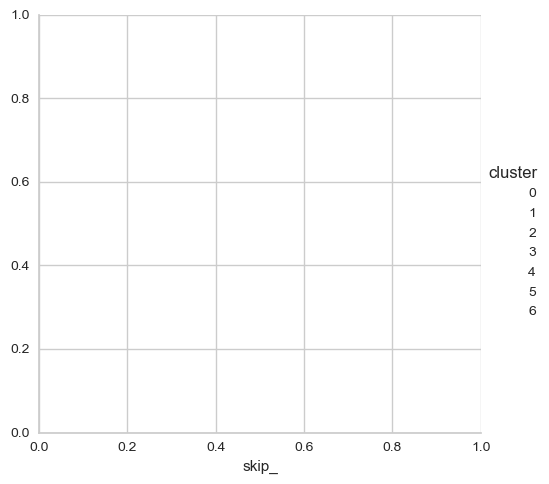

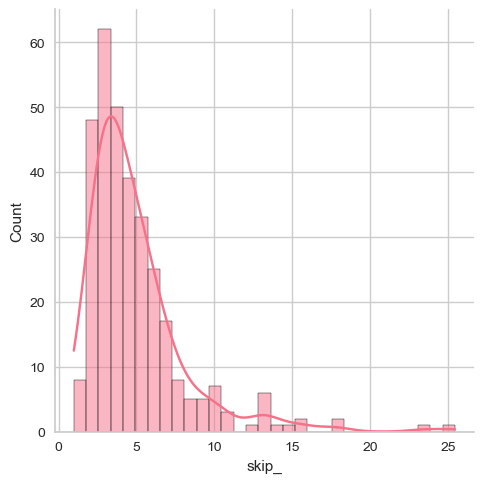

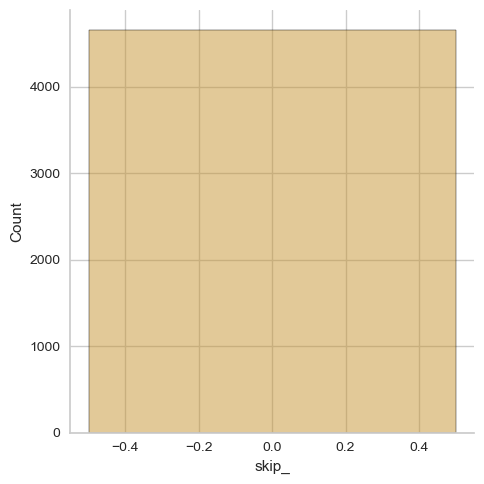

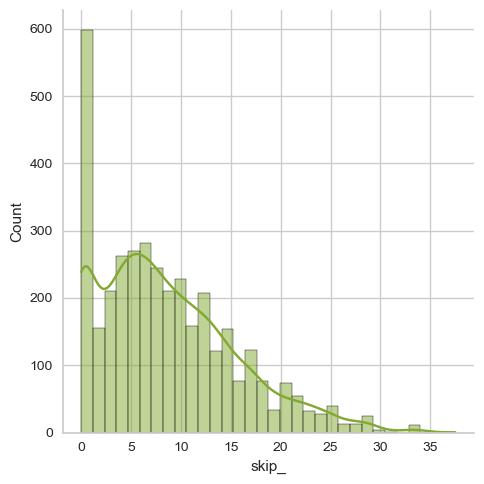

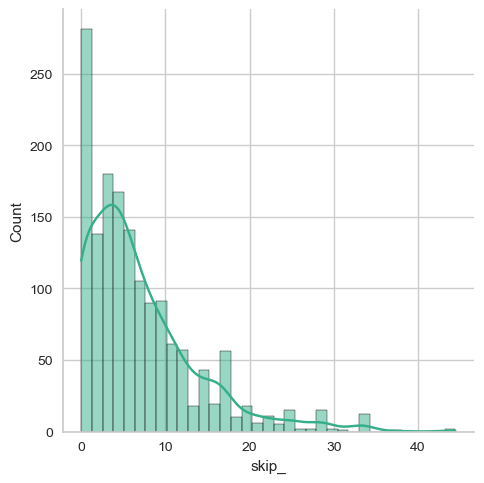

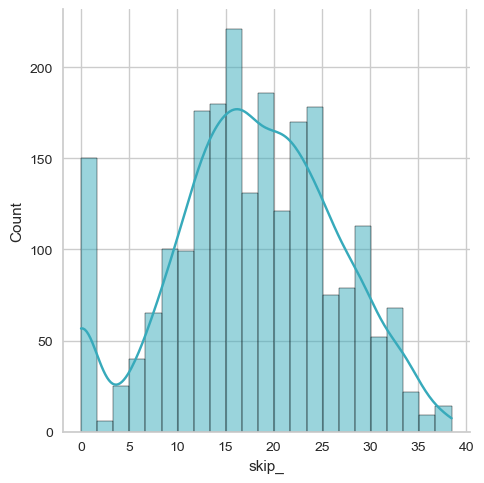

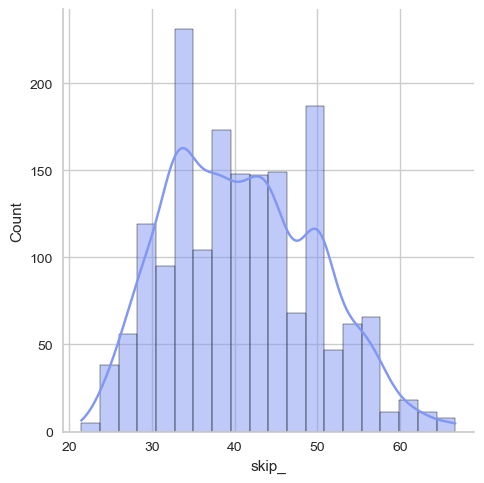

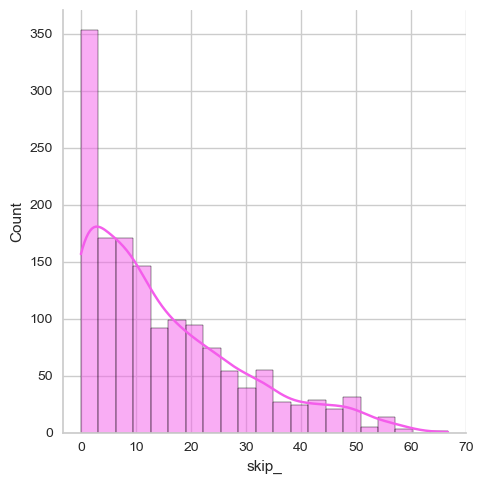

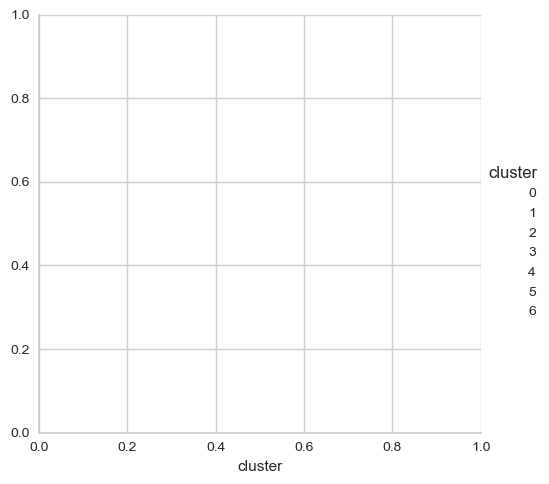

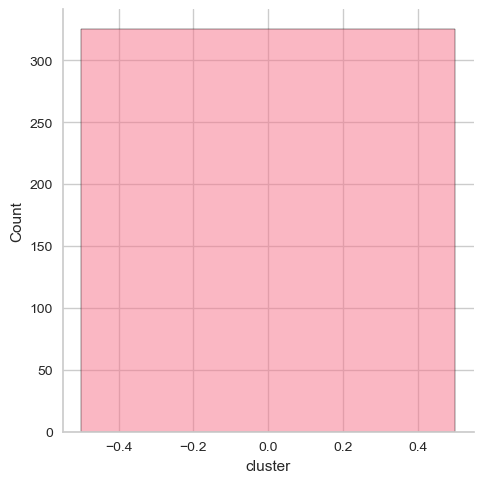

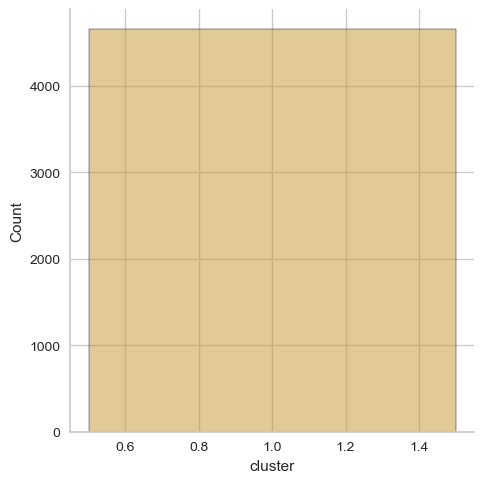

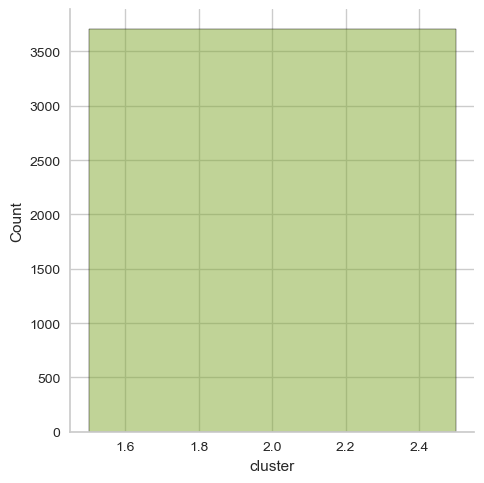

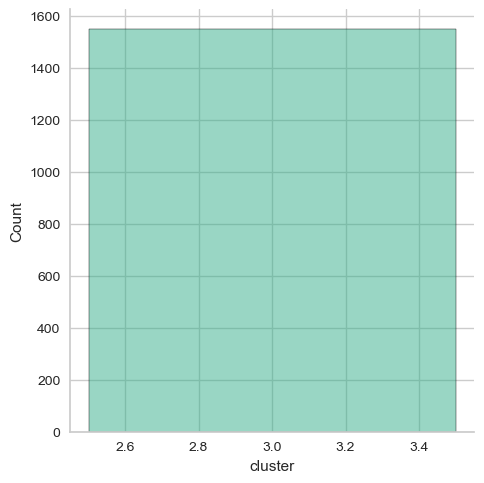

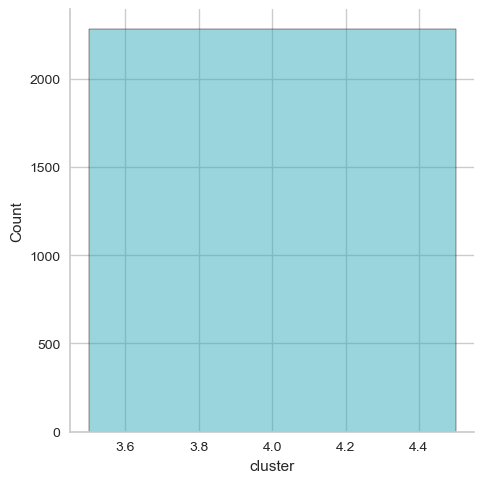

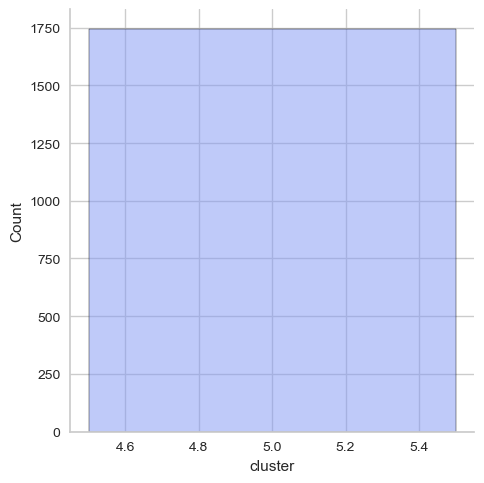

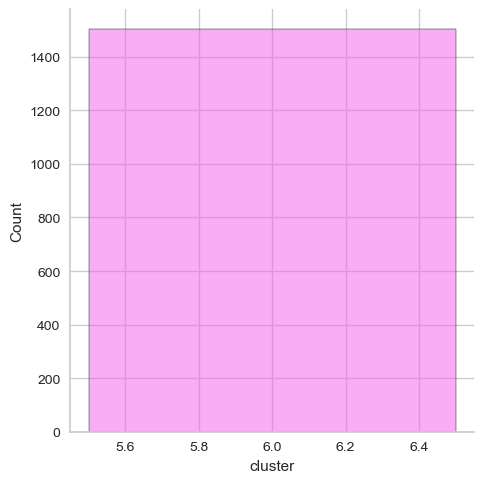

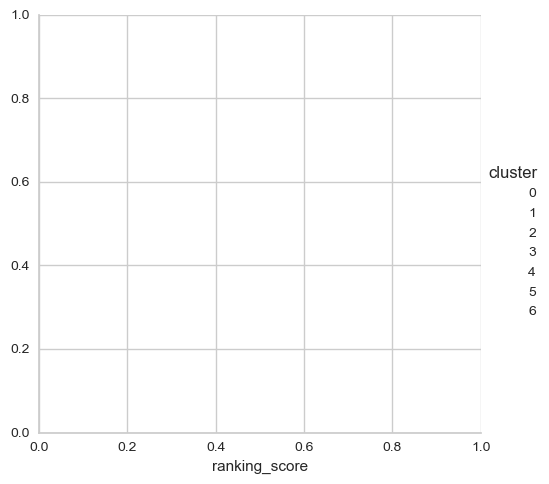

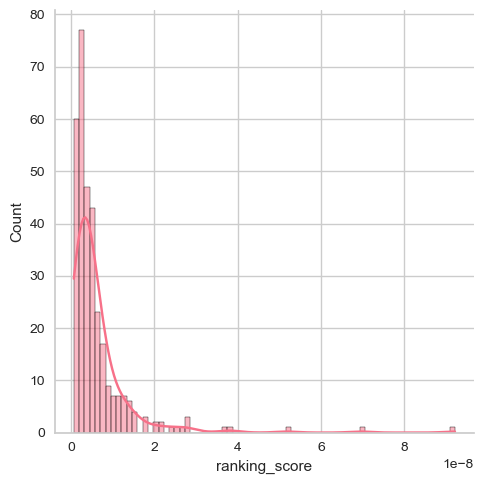

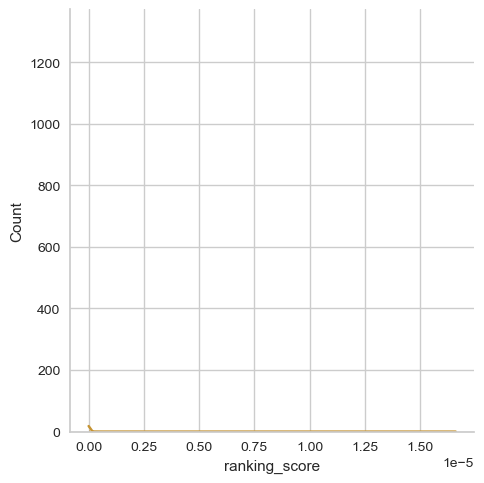

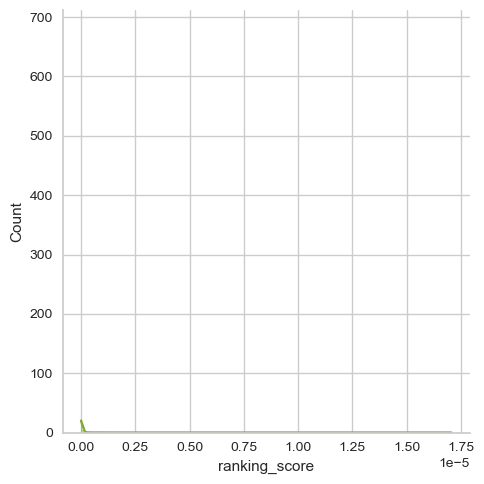

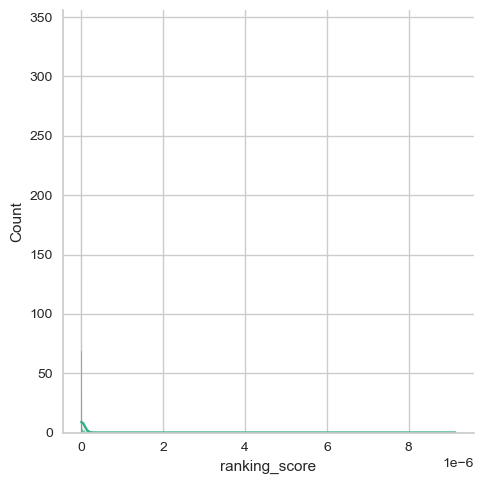

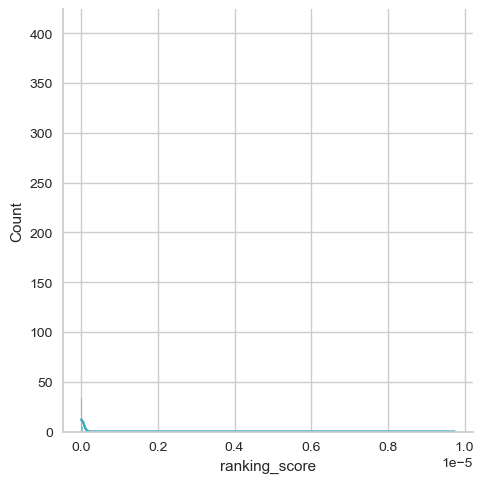

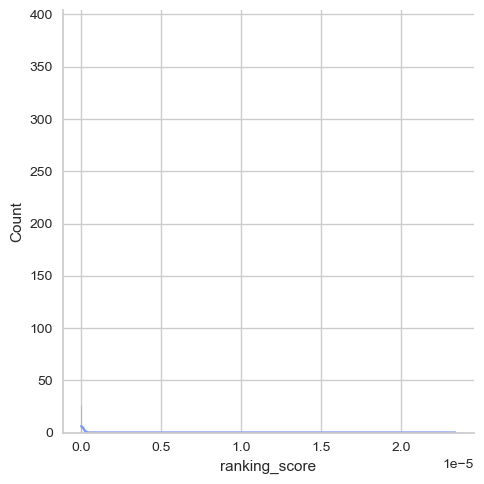

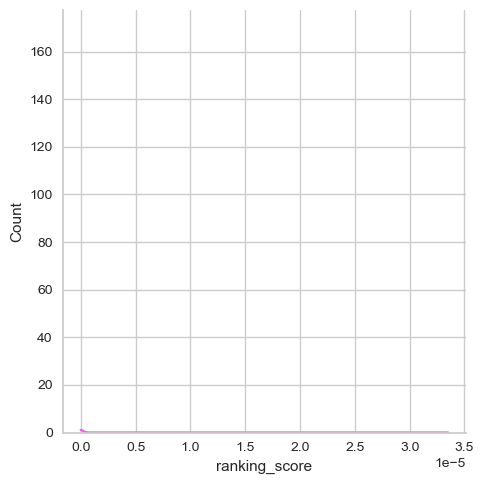

In [83]:
for feature in numericals.columns:
    sns.FacetGrid(numericals, hue="cluster", height=5).map(sns.displot, feature, kde=True).add_legend()
    plt.show()

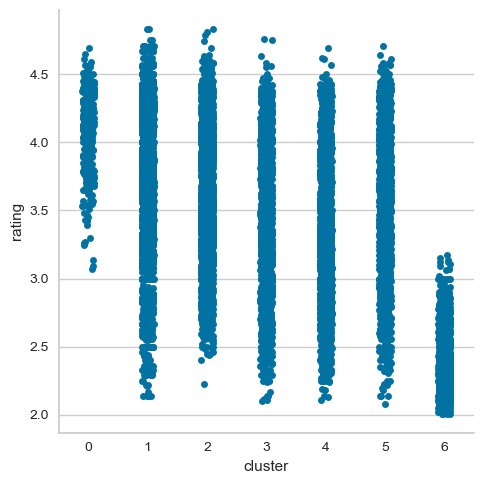

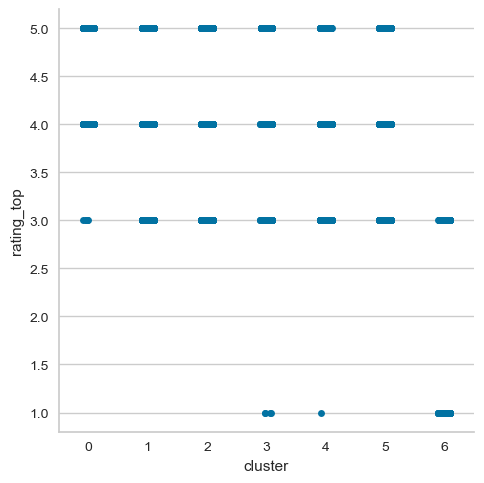

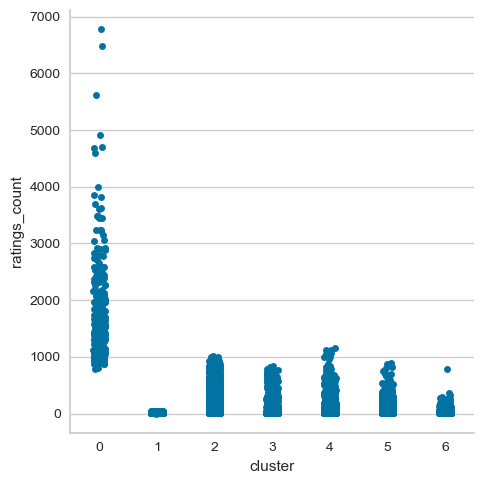

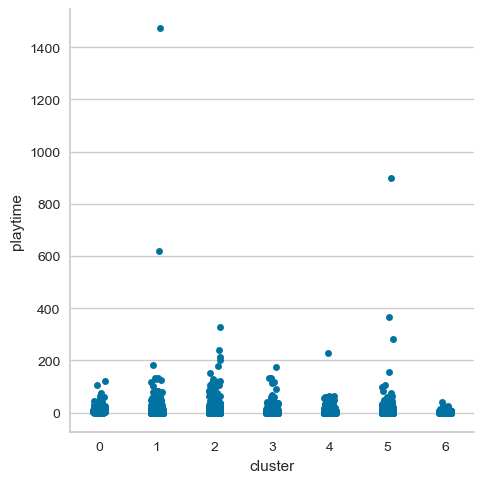

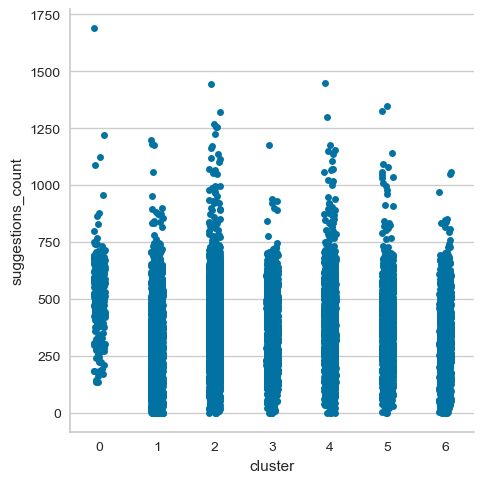

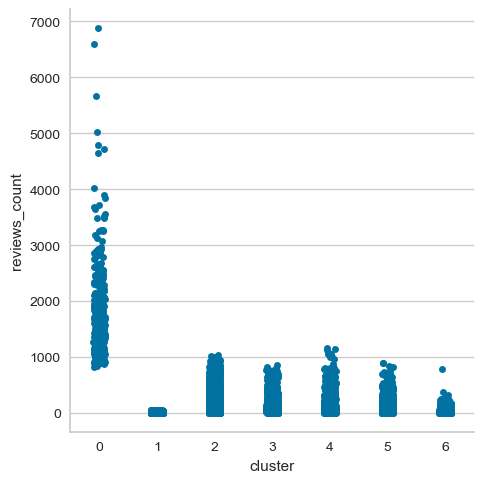

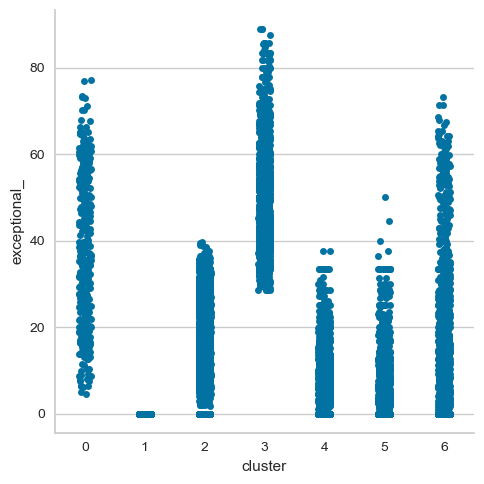

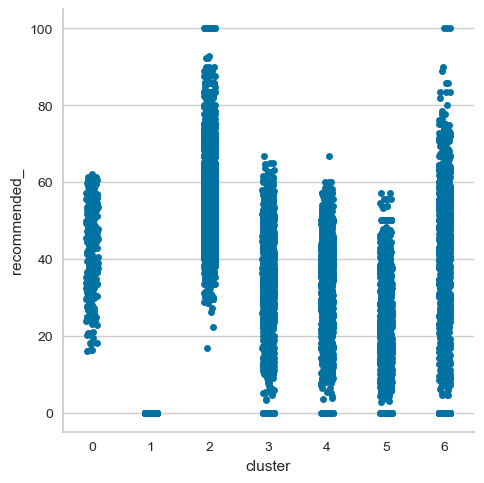

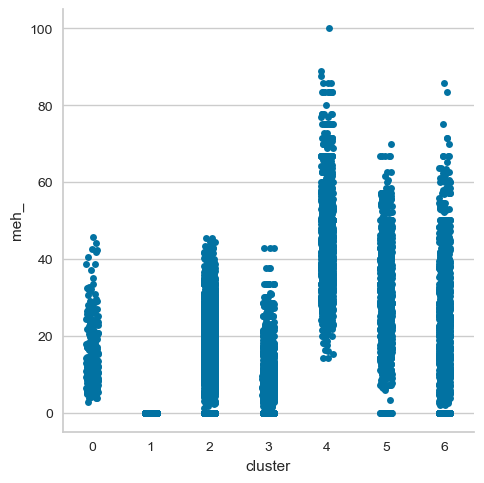

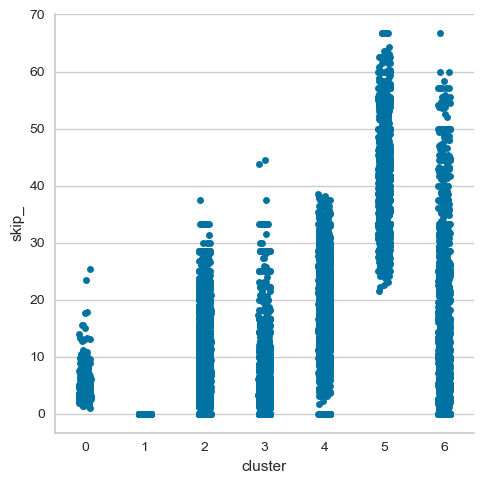

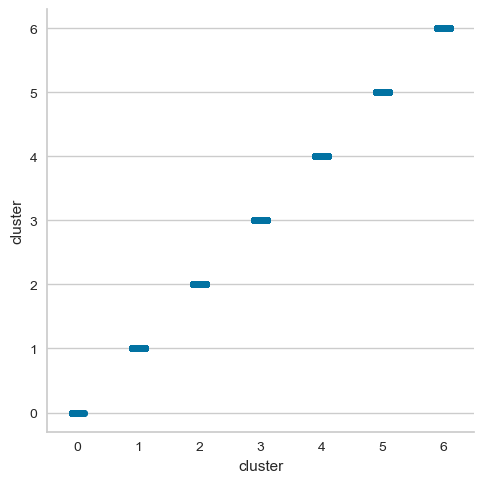

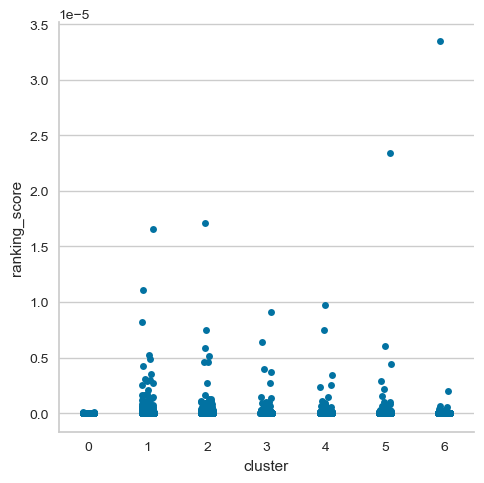

In [86]:
for col in numericals.columns:
    sns.catplot(x="cluster", y=f"{col}", data=numericals) 
    plt.show()

In [69]:
numericals.isna().sum()

rating                0
rating_top            0
ratings_count         0
playtime              0
suggestions_count     0
reviews_count         0
exceptional_          0
recommended_          0
meh_                  0
skip_                 0
cluster               0
ranking_score        14
dtype: int64

In [64]:
len(combined_df.columns)

25